<a href="https://colab.research.google.com/github/buriro-ezekia/-Hepatitis-B-Predictive-Modelling-and-Forecasting-Benjamin-Mkapa-Hospital-BMH-/blob/main/BMH_Longitudinal_Data_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**General objective**

The goal of this study is developing a Predictive model for Hepatitis B patients using hospital-records data from 2017 to 2024 at Benjamin Mkapa Hospital.

**Specific objective**

- To analyse hepatitis B patient trends at Benjamin Mkapa Hospital (BMH)
- To develop a Hepatitis B patient predictive model.
- To predict Hepatitis B patients at BMH over the next five years.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Data Cleaning**

In [ ]:
import pandas as pd

# Load the raw patient-level data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_ready.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710 entries, 0 to 1709
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OPIP_CODE       1710 non-null   object 
 1   UHID            1710 non-null   object 
 2   REGN_DT         1710 non-null   object 
 3   GENDER          1710 non-null   int64  
 4   AGE             1710 non-null   int64  
 5   VIRAL_LOAD      1710 non-null   float64
 6   ALT_LEVEL       1710 non-null   float64
 7   VIRAL_LOAD_LOG  1710 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 107.0+ KB


In [ ]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_ready.csv")

# 1. Remove Duplicates
df = df.drop_duplicates()

# 2. Correct Errors and Ensure Consistency in Patient IDs and Date Formats
# Standardize OPIP_CODE and UHID (remove spaces, uppercase)
df["OPIP_CODE"] = df["OPIP_CODE"].str.strip().str.upper()
df["UHID"] = df["UHID"].str.strip().str.upper()

# Convert REGN_DT to datetime
df["REGN_DT"] = pd.to_datetime(df["REGN_DT"],format='%d-%b-%Y %H.%M.%S', errors="coerce")
# Optionally drop rows with invalid dates
df = df.dropna(subset=["REGN_DT"])

# 3. Identify & Mark LTFU (Lost to Follow-Up)
# Assume you define LTFU as missing latest viral load or ALT_LEVEL, or by a rule (e.g., last visit > 12 months ago)
# Example: If REGN_DT is > 12 months from "today", mark as LTFU
today = pd.Timestamp.today()
df["LTFU"] = (today - df["REGN_DT"]).dt.days > 365  # LTFU if last visit > 1 year ago

# 4. MNAR Considerations
# Explore correlates of missingness, e.g. for VIRAL_LOAD or ALT_LEVEL
missing_vl = df["VIRAL_LOAD"].isna()
missing_alt = df["ALT_LEVEL"].isna()

# Check if missingness is related to gender, age, viral load, etc.
mnar_summary = df[missing_vl | missing_alt][["GENDER", "AGE", "VIRAL_LOAD", "ALT_LEVEL"]].describe(include="all")

# Document MNAR findings (print or save as a separate file)
mnar_summary.to_csv("drive/MyDrive/Rulinga II/MNAR_summary.csv")

# Optionally, fill missing values or leave them as is, depending on your analysis plan

# Save the cleaned dataset
df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_final.csv", index=False)

print("Data cleaning complete. Cleaned file saved as DIAGNOSIS_RESULTS_CLEANED_final.csv.")
print("MNAR summary saved as MNAR_summary.csv.")

Data cleaning complete. Cleaned file saved as DIAGNOSIS_RESULTS_CLEANED_final.csv.
MNAR summary saved as MNAR_summary.csv.


### Time Series Structuring

In [ ]:
import pandas as pd
import numpy as np

# Load cleaned dataset
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_final.csv", parse_dates=["REGN_DT"])

# 1. Monthly Aggregation (one row per patient per month)
df['month'] = df['REGN_DT'].dt.to_period('M')
monthly_df = df.groupby(['OPIP_CODE', 'month']).agg({
    'UHID': 'first',
    'GENDER': 'first',
    'AGE': 'first',
    'VIRAL_LOAD': 'mean',
    'ALT_LEVEL': 'mean',
    'VIRAL_LOAD_LOG': 'mean',
    'LTFU': 'max'
}).reset_index()
monthly_df['month'] = monthly_df['month'].dt.to_timestamp()
monthly_df = monthly_df.sort_values(['OPIP_CODE', 'month'])

# 2. Track Follow-Up (start/end times, duration)
followup_stats = df.groupby('OPIP_CODE')['REGN_DT'].agg(['min', 'max', 'count']).reset_index()
followup_stats['duration_days'] = (followup_stats['max'] - followup_stats['min']).dt.days
followup_stats.rename(columns={'min': 'start_date', 'max': 'end_date'}, inplace=True)

# 3. Yearly Aggregation (alternate dataset)
df['year'] = df['REGN_DT'].dt.year
yearly_df = df.groupby(['OPIP_CODE', 'year']).agg({
    'UHID': 'first',
    'GENDER': 'first',
    'AGE': 'first',
    'VIRAL_LOAD': 'mean',
    'ALT_LEVEL': 'mean',
    'VIRAL_LOAD_LOG': 'mean',
    'LTFU': 'max'
}).reset_index()
yearly_df = yearly_df.sort_values(['OPIP_CODE', 'year'])

# Save processed datasets
monthly_df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", index=False)
followup_stats.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_followup_stats.csv", index=False)
yearly_df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_yearly_agg.csv", index=False)

print("Monthly, yearly, and follow-up datasets saved successfully.")

Monthly, yearly, and follow-up datasets saved successfully.


## Exploratory Data Analysis (EDA)

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os

# # Ensure the plots directory exists
# plot_dir = "drive/MyDrive/Rulinga II/plots"
# os.makedirs(plot_dir, exist_ok=True)

# # --- 1. Load cleaned data and follow-up stats with correct date parsing ---
# # Use date_format if pandas >=2.0, otherwise use manual pd.to_datetime
# # Here, we use manual conversion for full compatibility

# # Load main dataset
# df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_final.csv")
# df['REGN_DT'] = pd.to_datetime(df['REGN_DT'], format='%d-%b-%Y %H.%M.%S', errors='coerce')

# # Load follow-up stats
# followup_stats = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_followup_stats.csv")
# followup_stats['start_date'] = pd.to_datetime(followup_stats['start_date'], format='%d-%b-%Y %H.%M.%S', errors='coerce')
# followup_stats['end_date'] = pd.to_datetime(followup_stats['end_date'], format='%d-%b-%Y %H.%M.%S', errors='coerce')

# # --- 2. Histogram: Follow-up duration (months/years) ---
# followup_stats['duration_months'] = followup_stats['duration_days'] / 30.44
# followup_stats['duration_years'] = followup_stats['duration_days'] / 365.25

# plt.figure(figsize=(8,5))
# sns.histplot(followup_stats['duration_months'], bins=20, kde=False) # Changed kde=True to kde=False
# plt.title('Histogram of Follow-Up Duration (Months)')
# plt.xlabel('Duration (months)')
# plt.ylabel('Number of Patients')
# plt.tight_layout()
# plt.savefig(f"{plot_dir}/hist_followup_months.png")
# # plt.close()
# plt.show()

# plt.figure(figsize=(8,5))
# sns.histplot(followup_stats['duration_years'], bins=10, kde=False) # Changed kde=True to kde=False
# plt.title('Histogram of Follow-Up Duration (Years)')
# plt.xlabel('Duration (years)')
# plt.ylabel('Number of Patients')
# plt.tight_layout()
# plt.savefig(f"{plot_dir}/hist_followup_years.png")
# # plt.close()
# plt.show()

# # --- 3. Censoring: Visualise LTFU (Lost to Follow-Up) ---
# early_ltfu = followup_stats[(followup_stats['duration_months'] < 6) & (followup_stats['duration_days'] > 0)]
# plt.figure(figsize=(8,5))
# sns.histplot(early_ltfu['duration_months'], bins=10, color="red", kde=False) # Changed kde=True to kde=False
# plt.title('Histogram of Early LTFU (Follow-Up < 6 Months)')
# plt.xlabel('Duration (months)')
# plt.ylabel('Number of Early LTFU Patients')
# plt.tight_layout()
# plt.savefig(f"{plot_dir}/hist_early_ltfu.png")
# # plt.close()
# plt.show()

# # Visualize censored vs. non-censored (LTFU status by duration)
# # Here, a patient is considered LTFU if their end_date is before the current date
# current_date = pd.Timestamp("2025-10-12")
# followup_stats['LTFU'] = followup_stats['end_date'] < current_date

# plt.figure(figsize=(8,5))
# sns.histplot(data=followup_stats, x='duration_months', hue='LTFU', bins=20, kde=False, palette={True:'red', False:'blue'}, alpha=0.7) # Changed kde=True to kde=False
# plt.title('Follow-Up Duration by Censoring Status')
# plt.xlabel('Duration (months)')
# plt.ylabel('Number of Patients')
# plt.tight_layout()
# plt.savefig(f"{plot_dir}/hist_censoring.png")
# # plt.close()
# plt.show()

# # --- 4. Missing Data Analysis ---
# # Patterns of drop-out related to baseline/time-varying factors
# missing_vl = df['VIRAL_LOAD'].isna()
# df['missing_vl'] = missing_vl

# # Compare baseline factors (AGE, GENDER) and time-varying (VIRAL_LOAD_LOG) for missing VL
# summary_missing = df.groupby('missing_vl')[['AGE', 'GENDER', 'VIRAL_LOAD_LOG']].mean()
# summary_missing.to_csv("drive/MyDrive/Rulinga II/missingness_summary.csv")

# # Little’s MCAR test is skipped due to import error in statsmodels.
# with open("drive/MyDrive/Rulinga II/littles_mcar_test.txt", "w") as f:
#     f.write("Little’s MCAR test was not run due to import error or unavailable package. Consider using the 'missingno' or 'statsmodels' library if available for MCAR/MAR/MNAR testing.\n")

# print("EDA complete. Plots saved under drive/MyDrive/Rulinga II/plots/.")
# print("Missingness summary and Little's MCAR test status saved.")

In [ ]:
print(df.columns)
print(followup_stats.columns)


Index(['OPIP_CODE', 'UHID', 'REGN_DT', 'GENDER', 'AGE', 'VIRAL_LOAD',
       'ALT_LEVEL', 'VIRAL_LOAD_LOG', 'LTFU', 'month', 'year'],
      dtype='object')
Index(['OPIP_CODE', 'start_date', 'end_date', 'count', 'duration_days'], dtype='object')


In [ ]:
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_final.csv")
df['REGN_DT'] = pd.to_datetime(df['REGN_DT'], format='%d-%b-%Y %H.%M.%S', errors='coerce')

# Check info
print(df.info())

# Check first few rows
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710 entries, 0 to 1709
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   OPIP_CODE       1710 non-null   object        
 1   UHID            1710 non-null   object        
 2   REGN_DT         0 non-null      datetime64[ns]
 3   GENDER          1710 non-null   int64         
 4   AGE             1710 non-null   int64         
 5   VIRAL_LOAD      1710 non-null   float64       
 6   ALT_LEVEL       1710 non-null   float64       
 7   VIRAL_LOAD_LOG  1710 non-null   float64       
 8   LTFU            1710 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 108.7+ KB
None
    OPIP_CODE                 UHID REGN_DT  GENDER  AGE  VIRAL_LOAD  \
0  IB19005210  1934-03-20 00:00:00     NaT       1   21      8309.0   
1  OB24217951  1938-03-14 00:00:00     NaT       1   57     17587.3   
2  IB2401029

In [ ]:
# Install command

!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 6.3 MB/s eta 0:00:00


Initial REGN_DT dtype: object
0    2019-11-13 12:00:00
1    2024-10-28 12:00:00
2    2024-10-29 12:00:00
3    2021-04-08 12:00:00
4    2022-05-26 12:00:00
Name: REGN_DT, dtype: object

Parsed REGN_DT dtype: datetime64[ns]
0   2019-11-13 12:00:00
1   2024-10-28 12:00:00
2   2024-10-29 12:00:00
3   2021-04-08 12:00:00
4   2022-05-26 12:00:00
Name: REGN_DT, dtype: datetime64[ns]
0.0 of rows are missing REGN_DT values

Latest registration date in dataset: 2024-12-31 12:00:00

Duration months statistics:
count    1710.000000
mean       16.064152
std        17.026501
min         0.000000
25%         4.200000
50%        10.300000
75%        20.200000
max        75.000000
Name: duration_months, dtype: float64

Merged duration_months statistics:
count    1710.000000
mean       16.064152
std        17.026501
min         0.000000
25%         4.200000
50%        10.300000
75%        20.200000
max        75.000000
Name: duration_months, dtype: float64

Distribution of Follow-Up Duration Among Patie

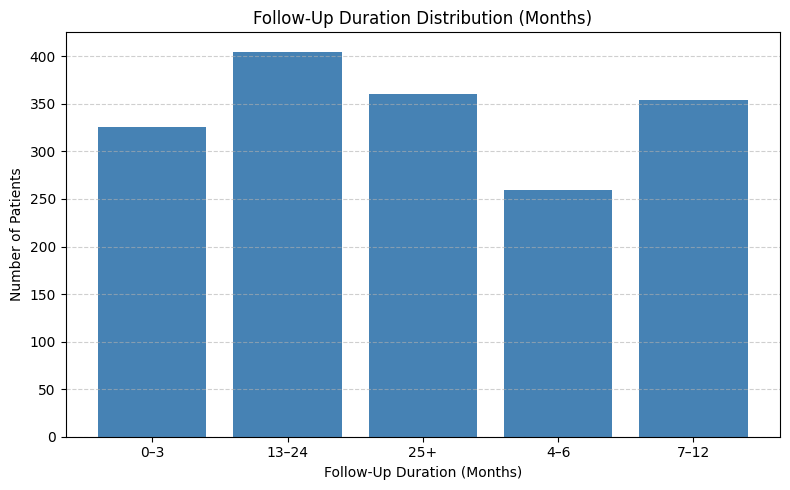

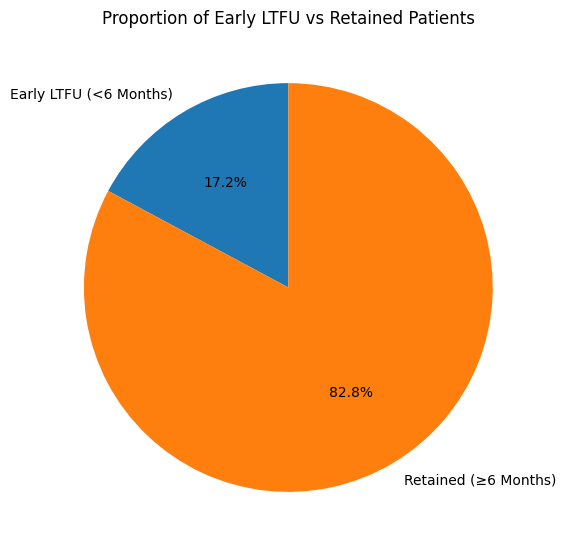


Exported Table successfully to drive/MyDrive/Rulinga II/Table_FollowUp_Duration.docx


In [ ]:
# -------------------------------------------------------------
# Hepatitis B Follow-Up Duration Analysis (BMH)
# -------------------------------------------------------------
# Purpose:
#   - Parse registration dates correctly
#   - Compute follow-up durations in months
#   - Merge durations into a new dataframe
#   - Generate Table and Figures
#   - Export the table to a Word file
# -------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
from docx import Document

# -------------------------------------------------------------
# Step 1. Load and check the dataset
# -------------------------------------------------------------
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_final.csv")

print("Initial REGN_DT dtype:", df['REGN_DT'].dtype)
print(df['REGN_DT'].head())

# -------------------------------------------------------------
# Step 2. Parse REGN_DT into datetime
# -------------------------------------------------------------
df['REGN_DT'] = pd.to_datetime(df['REGN_DT'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# Fallback flexible parsing if any rows remain unparsed
if df['REGN_DT'].isna().any():
    df['REGN_DT'] = pd.to_datetime(df['REGN_DT'], errors='coerce')

print("\nParsed REGN_DT dtype:", df['REGN_DT'].dtype)
print(df['REGN_DT'].head())
print(df['REGN_DT'].isna().mean(), "of rows are missing REGN_DT values")

# -------------------------------------------------------------
# Step 3. Compute follow-up duration (months)
# -------------------------------------------------------------
if not pd.api.types.is_datetime64_any_dtype(df['REGN_DT']):
    raise TypeError("REGN_DT column must be datetime64 type before duration computation.")

latest_date = df['REGN_DT'].max()
print("\nLatest registration date in dataset:", latest_date)

# Use .dt.days to safely extract numeric difference
df['duration_months'] = (latest_date - df['REGN_DT']).dt.days / 30.44
df['duration_months'] = df['duration_months'].round(1)

print("\nDuration months statistics:")
print(df['duration_months'].describe())

# -------------------------------------------------------------
# Step 4. Prepare for merge into a new dataframe
# -------------------------------------------------------------
# Load the monthly long-form data which has patient-level information aggregated by month
df_combined = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv")

df['OPIP_CODE'] = df['OPIP_CODE'].astype(str).str.strip().str.upper()
df_combined['OPIP_CODE'] = df_combined['OPIP_CODE'].astype(str).str.strip().str.upper()

# Drop any previous duration column to avoid conflicts
if 'duration_months' in df_combined.columns:
    df_combined = df_combined.drop(columns=['duration_months'])

# Merge duration values
df_combined = df_combined.merge(
    df[['OPIP_CODE', 'duration_months']],
    on='OPIP_CODE',
    how='left'
)

print("\nMerged duration_months statistics:")
print(df_combined['duration_months'].describe())

# -------------------------------------------------------------
# Step 5. Clean valid duration data
# -------------------------------------------------------------
df_combined['duration_months'] = pd.to_numeric(df_combined['duration_months'], errors='coerce')
df_combined = df_combined[(df_combined['duration_months'] > 0) & (df_combined['duration_months'].notna())]

if df_combined.empty:
    raise ValueError("No valid follow-up duration data available after cleaning.")

# -------------------------------------------------------------
# Step 6. Create duration groups and summary table
# -------------------------------------------------------------
min_dur = df_combined['duration_months'].min()
max_dur = df_combined['duration_months'].max()

bins = [0, 3, 6, 12, 24, max(25, round(max_dur) + 1)]
labels = ['0–3', '4–6', '7–12', '13–24', '25+']

df_combined['duration_group'] = pd.cut(
    df_combined['duration_months'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
).astype(str)

# Build summary table safely — this time fix column naming logic
table = (
    df_combined['duration_group']
    .value_counts()
    .sort_index()
    .reset_index()
)

# Rename explicitly to avoid KeyError
table.columns = ['Follow-Up Duration (Months)', 'Number of Patients']

# Ensure numeric column type
table['Number of Patients'] = pd.to_numeric(table['Number of Patients'], errors='coerce')

# Compute percentages
table['Percentage (%)'] = (table['Number of Patients'] / table['Number of Patients'].sum() * 100).round(1)

# Classification logic
def classify_ltfu(group):
    if group in ['0–3', '4–6']:
        return 'Early LTFU'
    elif group == '7–12':
        return 'Short-Term Follow-Up'
    elif group == '13–24':
        return 'Medium-Term'
    else:
        return 'Long-Term Retained'

table['LTFU Classification'] = table['Follow-Up Duration (Months)'].apply(classify_ltfu)

# Add total row
total_row = pd.DataFrame({
    'Follow-Up Duration (Months)': ['Total'],
    'Number of Patients': [table['Number of Patients'].sum()],
    'Percentage (%)': [table['Percentage (%)'].sum()],
    'LTFU Classification': ['']
})
table = pd.concat([table, total_row], ignore_index=True)

print("\nDistribution of Follow-Up Duration Among Patients")
print(table.to_string(index=False))

# -------------------------------------------------------------
# Step 7. Plot Figures
# -------------------------------------------------------------
# Follow-Up Duration Distribution
plt.figure(figsize=(8,5))
plt.bar(table['Follow-Up Duration (Months)'][:-1], table['Number of Patients'][:-1], color='steelblue')
plt.title("Follow-Up Duration Distribution (Months)", fontsize=12)
plt.xlabel("Follow-Up Duration (Months)")
plt.ylabel("Number of Patients")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Early LTFU vs Retained
early_ltfu = table.loc[table['LTFU Classification'] == 'Early LTFU', 'Number of Patients'].sum()
retained = table['Number of Patients'].sum() - early_ltfu

if early_ltfu > 0 and retained > 0:
    plt.figure(figsize=(6,6))
    plt.pie(
        [early_ltfu, retained],
        labels=['Early LTFU (<6 Months)', 'Retained (≥6 Months)'],
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title("Proportion of Early LTFU vs Retained Patients", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot Early LTFU vs Retained Patients.")

# -------------------------------------------------------------
# Step 8. Export a Table to Word
# -------------------------------------------------------------
doc = Document()
doc.add_heading("Distribution of Follow-Up Duration Among Patients", level=2)

t = doc.add_table(rows=1, cols=len(table.columns))
hdr_cells = t.rows[0].cells
for i, col in enumerate(table.columns):
    hdr_cells[i].text = col

for _, row in table.iterrows():
    row_cells = t.add_row().cells
    for i, val in enumerate(row):
        row_cells[i].text = str(val)

output_path = "drive/MyDrive/Rulinga II/Table_FollowUp_Duration.docx"
doc.save(output_path)
print(f"\nExported Table successfully to {output_path}")

### Trend & Descriptive Analysis

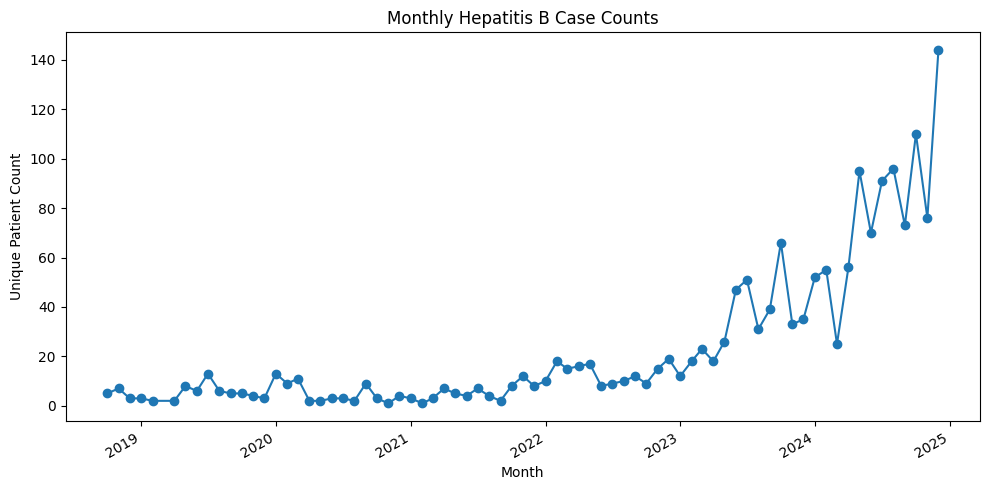

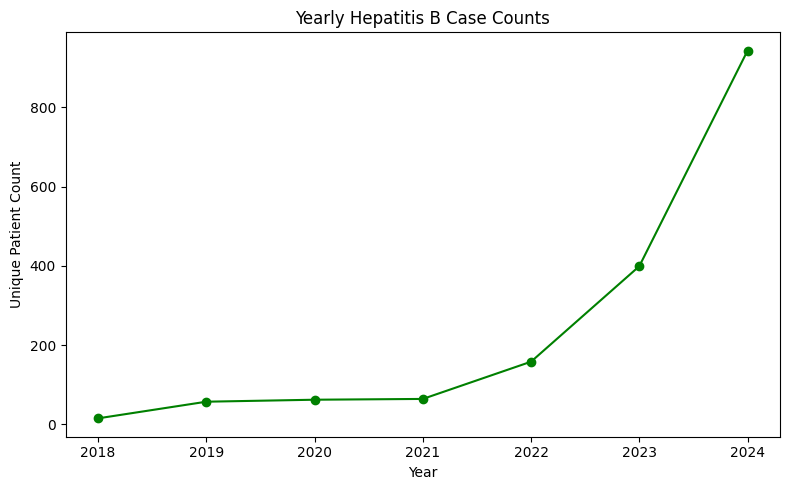

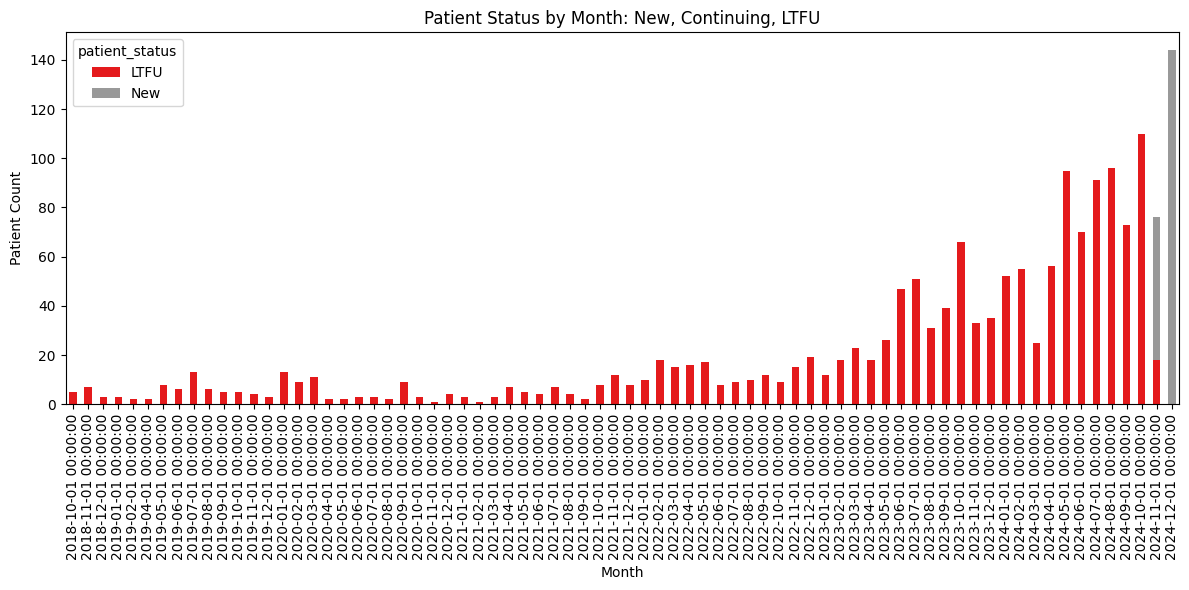

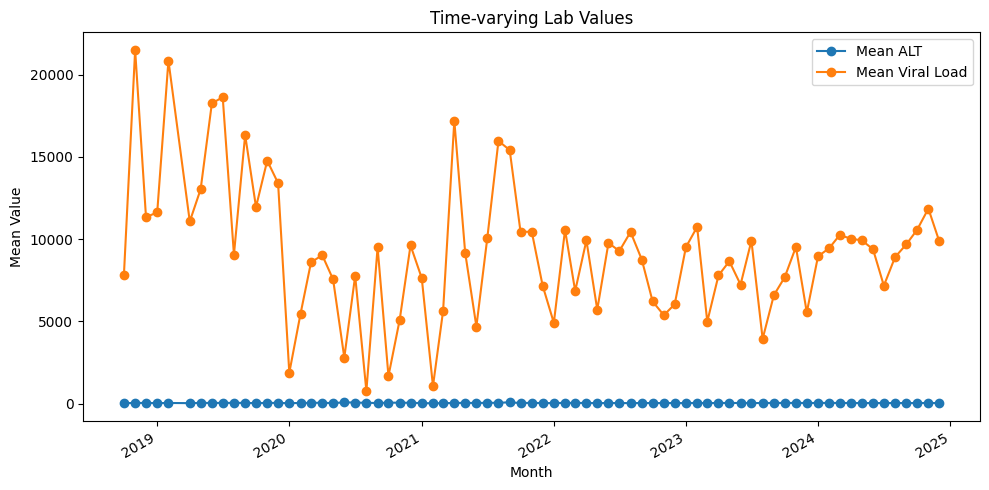

Trend and descriptive analysis complete. Plots and summary files saved.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Paths
monthly_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv"
yearly_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_yearly_agg.csv"
plot_dir = "drive/MyDrive/Rulinga II/plots"
os.makedirs(plot_dir, exist_ok=True)

# Load Data
monthly_df = pd.read_csv(monthly_path, parse_dates=['month'])
yearly_df = pd.read_csv(yearly_path)

# ---- 1. Trends: Monthly/Yearly Hepatitis B Case Counts ----
monthly_counts = monthly_df.groupby('month')['OPIP_CODE'].nunique()
plt.figure(figsize=(10,5))
monthly_counts.plot(marker='o')
plt.title('Monthly Hepatitis B Case Counts')
plt.xlabel('Month')
plt.ylabel('Unique Patient Count')
plt.tight_layout()
plt.savefig(f"{plot_dir}/monthly_case_counts.png")
# plt.close()
plt.show()

yearly_counts = yearly_df.groupby('year')['OPIP_CODE'].nunique()
plt.figure(figsize=(8,5))
yearly_counts.plot(marker='o', color='green')
plt.title('Yearly Hepatitis B Case Counts')
plt.xlabel('Year')
plt.ylabel('Unique Patient Count')
plt.tight_layout()
plt.savefig(f"{plot_dir}/yearly_case_counts.png")
# plt.close()
plt.show()

# ---- 2. Patient Status: New, Continuing, and LTFU per Month ----
monthly_df = monthly_df.sort_values(['OPIP_CODE', 'month'])
monthly_df['first_month'] = monthly_df.groupby('OPIP_CODE')['month'].transform('min')
monthly_df['patient_status'] = 'Continuing'
monthly_df.loc[monthly_df['month'] == monthly_df['first_month'], 'patient_status'] = 'New'
monthly_df.loc[monthly_df['LTFU'] == 1, 'patient_status'] = 'LTFU'

status_counts = monthly_df.groupby(['month', 'patient_status'])['OPIP_CODE'].nunique().reset_index()
status_pivot = status_counts.pivot(index='month', columns='patient_status', values='OPIP_CODE').fillna(0)

plt.figure(figsize=(12,6))
status_pivot.plot(kind='bar', stacked=True, colormap='Set1', ax=plt.gca())
plt.title('Patient Status by Month: New, Continuing, LTFU')
plt.xlabel('Month')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.savefig(f"{plot_dir}/monthly_patient_status.png")
# plt.close()
plt.show()

# ---- 3. Descriptive Statistics: Static and Time-varying ----
# Static: Demographics at first observation
static_df = monthly_df[monthly_df['month'] == monthly_df['first_month']]
static_stats = static_df[['AGE', 'GENDER']].describe()
static_stats.to_csv("drive/MyDrive/Rulinga II/static_descriptive_stats.csv")

# Time-varying: Labs over time
lab_stats = monthly_df[['month', 'VIRAL_LOAD', 'ALT_LEVEL', 'VIRAL_LOAD_LOG']].groupby('month').describe()
lab_stats.to_csv("drive/MyDrive/Rulinga II/lab_timevarying_stats.csv")

# Optional: Plot mean ALT and VL over time
plt.figure(figsize=(10,5))
monthly_df.groupby('month')['ALT_LEVEL'].mean().plot(label='Mean ALT', marker='o')
monthly_df.groupby('month')['VIRAL_LOAD'].mean().plot(label='Mean Viral Load', marker='o')
plt.title('Time-varying Lab Values')
plt.xlabel('Month')
plt.ylabel('Mean Value')
plt.legend()
plt.tight_layout()
plt.savefig(f"{plot_dir}/monthly_lab_trends.png")
# plt.close()
plt.show()

print("Trend and descriptive analysis complete. Plots and summary files saved.")

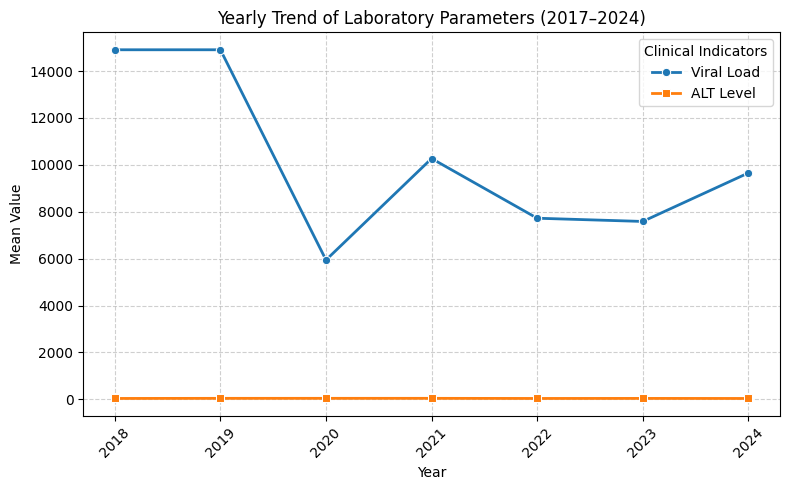

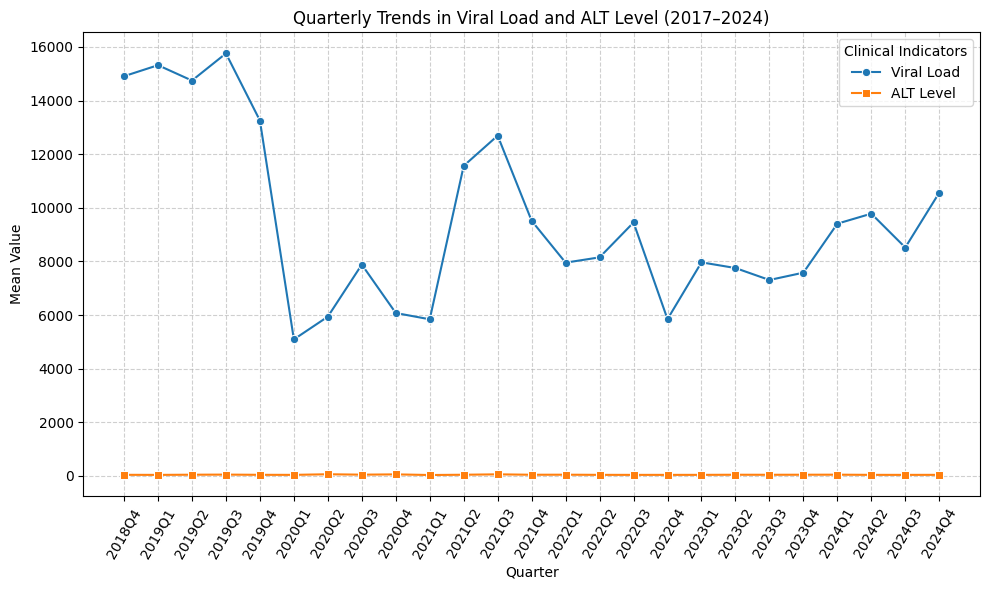

Trend and descriptive analysis complete. Clean plots and summary files saved in:
 - drive/MyDrive/Rulinga II/plots/yearly_lab_trends.png
 - drive/MyDrive/Rulinga II/plots/quarterly_lab_trends.png


In [ ]:
# -------------------------------------------------------------
# Hepatitis B Trend and Descriptive Analysis (BMH)
# -------------------------------------------------------------
# Purpose: Plot yearly and quarterly trends for Hepatitis B data
# -------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------------------------------------------
# Step 1. Paths and directory setup
# -------------------------------------------------------------
monthly_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv"
yearly_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_yearly_agg.csv"
plot_dir = "drive/MyDrive/Rulinga II/plots"
os.makedirs(plot_dir, exist_ok=True)

# -------------------------------------------------------------
# Step 2. Load data
# -------------------------------------------------------------
monthly_df = pd.read_csv(monthly_path)
yearly_df = pd.read_csv(yearly_path)

# -------------------------------------------------------------
# Step 3. Date cleaning and formatting
# -------------------------------------------------------------
# Strip the hours (00:00:00) for clarity
for df in [monthly_df, yearly_df]:
    # Handle potential missing date columns in the loop
    if 'REGN_DT' in df.columns:
        df['REGN_DT'] = pd.to_datetime(df['REGN_DT'], errors='coerce')
        df['REGN_DATE'] = df['REGN_DT'].dt.date
    elif 'month' in df.columns:
        # convert to datetime if month available
        df['month'] = pd.to_datetime(df['month'], errors='coerce')
        # Keep as datetime for plotting, not period
        # df['month'] = df['month'].dt.to_period('M').dt.to_timestamp()


# -------------------------------------------------------------
# Step 4. Aggregate data (Quarterly and Yearly Mean Lab Values)
# -------------------------------------------------------------
# Quarterly aggregation to reduce label crowding
if 'month' in monthly_df.columns:
    monthly_df['quarter'] = monthly_df['month'].dt.to_period('Q')
    quarterly_df = (
        monthly_df.groupby('quarter')
        .agg({'VIRAL_LOAD': 'mean', 'ALT_LEVEL': 'mean'})
        .reset_index()
    )
    quarterly_df['quarter'] = quarterly_df['quarter'].astype(str)

# Yearly aggregation of mean lab values across all patients for plotting
if 'year' in yearly_df.columns:
    yearly_agg_lab_trends = yearly_df.groupby('year').agg({
        'VIRAL_LOAD': 'mean',
        'ALT_LEVEL': 'mean'
    }).reset_index()


# -------------------------------------------------------------
# Step 5. Plot Yearly Trend of Lab Parameters
# -------------------------------------------------------------
# Use the yearly aggregated dataframe for plotting mean trends
if 'yearly_agg_lab_trends' in locals() and not yearly_agg_lab_trends.empty:
    plt.figure(figsize=(8, 5))
    # Plot Viral Load trend
    sns.lineplot(data=yearly_agg_lab_trends, x='year', y='VIRAL_LOAD', marker='o', linewidth=2, label='Viral Load')
    # Plot ALT Level trend
    sns.lineplot(data=yearly_agg_lab_trends, x='year', y='ALT_LEVEL', marker='s', linewidth=2, label='ALT Level')

    plt.title('Yearly Trend of Laboratory Parameters (2017–2024)', fontsize=12)
    plt.xlabel('Year')
    plt.ylabel('Mean Value')
    plt.xticks(yearly_agg_lab_trends['year'], rotation=45)  # Use actual years from data for xticks
    plt.legend(title='Clinical Indicators')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/yearly_lab_trends.png")
    plt.show()
else:
    print("Skipping Yearly Trend plot: Data for yearly aggregation not available or empty.")


# -------------------------------------------------------------
# Step 6. Plot Quarterly Trend of Lab Parameters
# -------------------------------------------------------------
if 'quarterly_df' in locals() and not quarterly_df.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=quarterly_df, x='quarter', y='VIRAL_LOAD', label='Viral Load', marker='o')
    sns.lineplot(data=quarterly_df, x='quarter', y='ALT_LEVEL', label='ALT Level', marker='s')
    plt.title('Quarterly Trends in Viral Load and ALT Level (2017–2024)', fontsize=12)
    plt.xlabel('Quarter')
    plt.ylabel('Mean Value')
    plt.xticks(rotation=60)  # angled labels to avoid overlap
    plt.legend(title='Clinical Indicators')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/quarterly_lab_trends.png")
    plt.show()
else:
    print("Skipping Quarterly Trend plot: Data for quarterly aggregation not available or empty.")


# -------------------------------------------------------------
# Step 7. Summary printout
# -------------------------------------------------------------
print("Trend and descriptive analysis complete. Clean plots and summary files saved in:")
print(f" - {plot_dir}/yearly_lab_trends.png")
print(f" - {plot_dir}/quarterly_lab_trends.png")

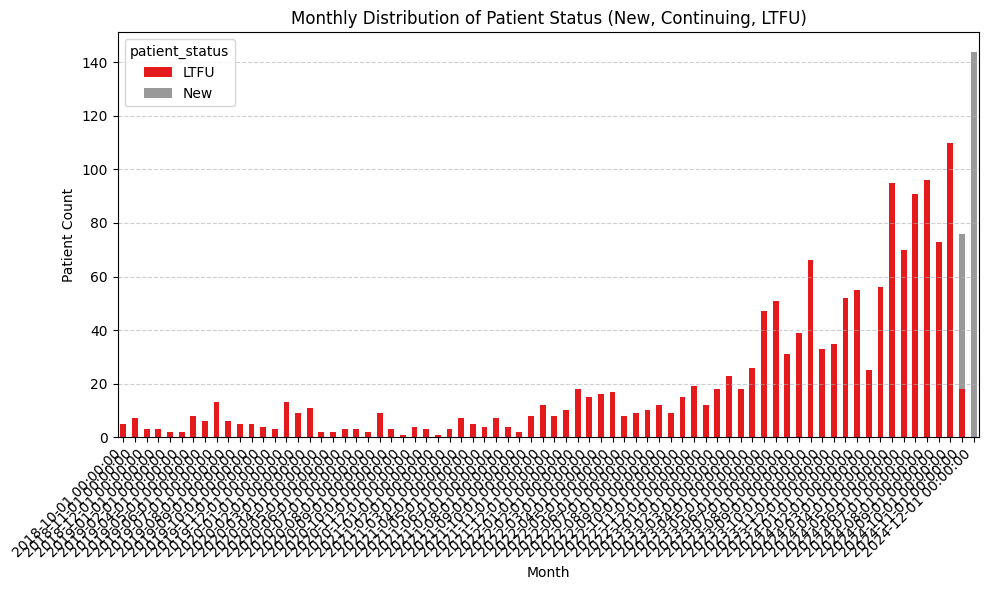

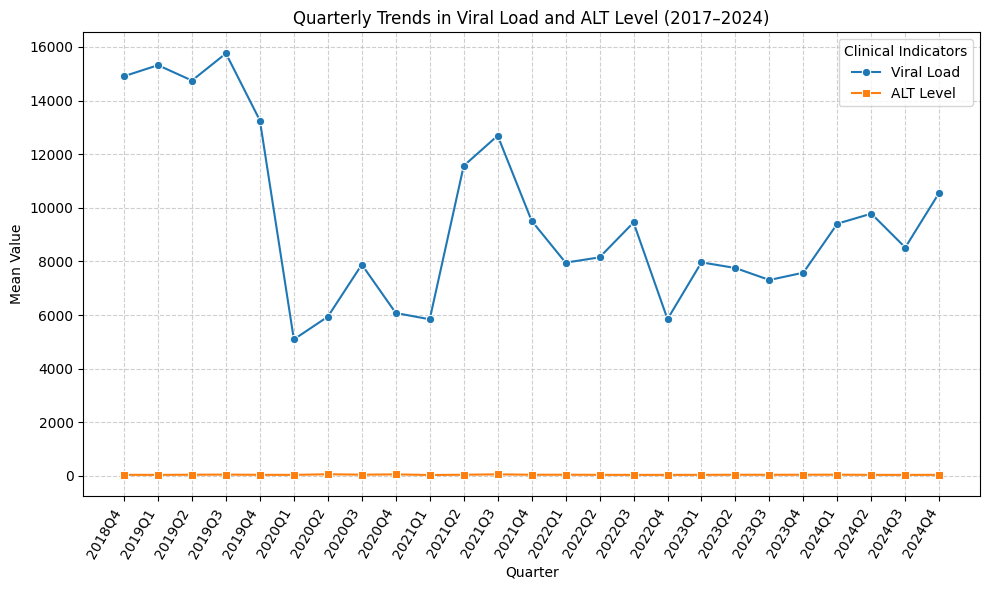

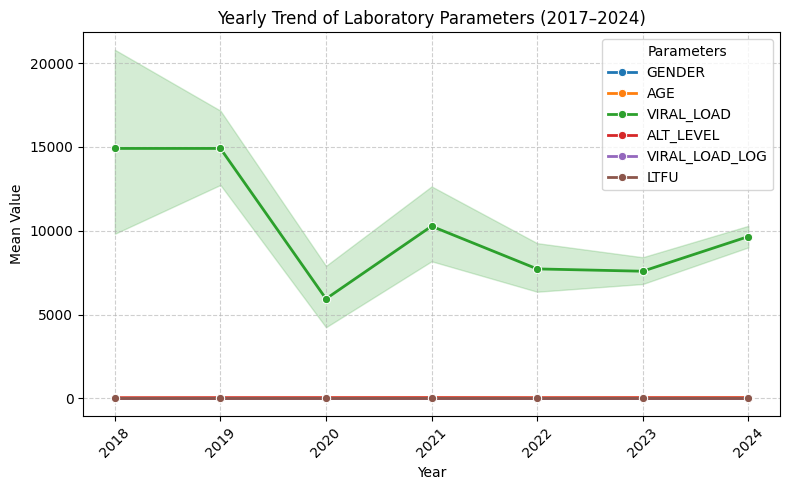

Trend and descriptive analysis complete. Outputs saved:
 - drive/MyDrive/Rulinga II/plots/monthly_patient_status.png
 - drive/MyDrive/Rulinga II/plots/quarterly_lab_trends.png
 - drive/MyDrive/Rulinga II/plots/yearly_lab_trends.png


In [ ]:
# -------------------------------------------------------------
# Hepatitis B Trend and Descriptive Analysis (BMH)
# -------------------------------------------------------------
# Purpose:
#   - Plot yearly and quarterly trends
#   - Compute patient status (New, Continuing, LTFU)
#   - Handle missing 'mean_value' dynamically
# -------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------------------------------------------
# Step 1. Paths and setup
# -------------------------------------------------------------
monthly_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv"
yearly_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_yearly_agg.csv"
plot_dir = "drive/MyDrive/Rulinga II/plots"
os.makedirs(plot_dir, exist_ok=True)

# -------------------------------------------------------------
# Step 2. Load datasets
# -------------------------------------------------------------
monthly_df = pd.read_csv(monthly_path)
yearly_df = pd.read_csv(yearly_path)

# -------------------------------------------------------------
# Step 3. Clean and format date columns
# -------------------------------------------------------------
if 'month' in monthly_df.columns:
    monthly_df['month'] = pd.to_datetime(monthly_df['month'], errors='coerce')
    monthly_df['month'] = monthly_df['month'].dt.to_period('M').dt.to_timestamp()  # Strip hours
if 'REGN_DT' in yearly_df.columns:
    yearly_df['REGN_DT'] = pd.to_datetime(yearly_df['REGN_DT'], errors='coerce')
if 'year' not in yearly_df.columns and 'REGN_DT' in yearly_df.columns:
    yearly_df['year'] = yearly_df['REGN_DT'].dt.year

# -------------------------------------------------------------
# Step 4. Patient Status: New, Continuing, and LTFU per Month
# -------------------------------------------------------------
monthly_df = monthly_df.sort_values(['OPIP_CODE', 'month'])
monthly_df['first_month'] = monthly_df.groupby('OPIP_CODE')['month'].transform('min')

# Initialise patient status
monthly_df['patient_status'] = 'Continuing'
monthly_df.loc[monthly_df['month'] == monthly_df['first_month'], 'patient_status'] = 'New'
if 'LTFU' in monthly_df.columns:
    monthly_df.loc[monthly_df['LTFU'] == 1, 'patient_status'] = 'LTFU'

# Aggregate counts
status_counts = (
    monthly_df.groupby(['month', 'patient_status'])['OPIP_CODE']
    .nunique()
    .reset_index()
)
status_pivot = status_counts.pivot(
    index='month', columns='patient_status', values='OPIP_CODE'
).fillna(0)

# -------------------------------------------------------------
# Step 5. Plot Patient Status Distribution (Stacked Bar)
# -------------------------------------------------------------
plt.figure(figsize=(10, 6))
status_pivot.plot(kind='bar', stacked=True, colormap='Set1', ax=plt.gca())
plt.title('Monthly Distribution of Patient Status (New, Continuing, LTFU)', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Patient Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f"{plot_dir}/monthly_patient_status.png")
plt.show()

# -------------------------------------------------------------
# Step 6. Aggregate Quarterly Data for Trend Smoothing
# -------------------------------------------------------------
monthly_df['quarter'] = monthly_df['month'].dt.to_period('Q')
quarterly_df = (
    monthly_df.groupby('quarter')
    .agg({'VIRAL_LOAD': 'mean', 'ALT_LEVEL': 'mean'})
    .reset_index()
)
quarterly_df['quarter'] = quarterly_df['quarter'].astype(str)

# -------------------------------------------------------------
# Step 7. Plot Quarterly Trends (Viral Load & ALT)
# -------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(data=quarterly_df, x='quarter', y='VIRAL_LOAD', label='Viral Load', marker='o')
sns.lineplot(data=quarterly_df, x='quarter', y='ALT_LEVEL', label='ALT Level', marker='s')
plt.title('Quarterly Trends in Viral Load and ALT Level (2017–2024)', fontsize=12)
plt.xlabel('Quarter')
plt.ylabel('Mean Value')
plt.xticks(rotation=60, ha='right')
plt.legend(title='Clinical Indicators')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f"{plot_dir}/quarterly_lab_trends.png")
plt.show()

# -------------------------------------------------------------
# Step 8. Plot Yearly Trends (Auto-detect numeric columns)
# -------------------------------------------------------------
numeric_cols = [col for col in yearly_df.columns if yearly_df[col].dtype != 'object' and col != 'year']

if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found in yearly_df to plot.")

plt.figure(figsize=(8, 5))
for col in numeric_cols:
    sns.lineplot(data=yearly_df, x='year', y=col, marker='o', linewidth=2, label=col)

plt.title('Yearly Trend of Laboratory Parameters (2017–2024)', fontsize=12)
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.legend(title='Parameters')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f"{plot_dir}/yearly_lab_trends.png")
plt.show()

# -------------------------------------------------------------
# Step 9. Output summary
# -------------------------------------------------------------
print("Trend and descriptive analysis complete. Outputs saved:")
print(f" - {plot_dir}/monthly_patient_status.png")
print(f" - {plot_dir}/quarterly_lab_trends.png")
print(f" - {plot_dir}/yearly_lab_trends.png")


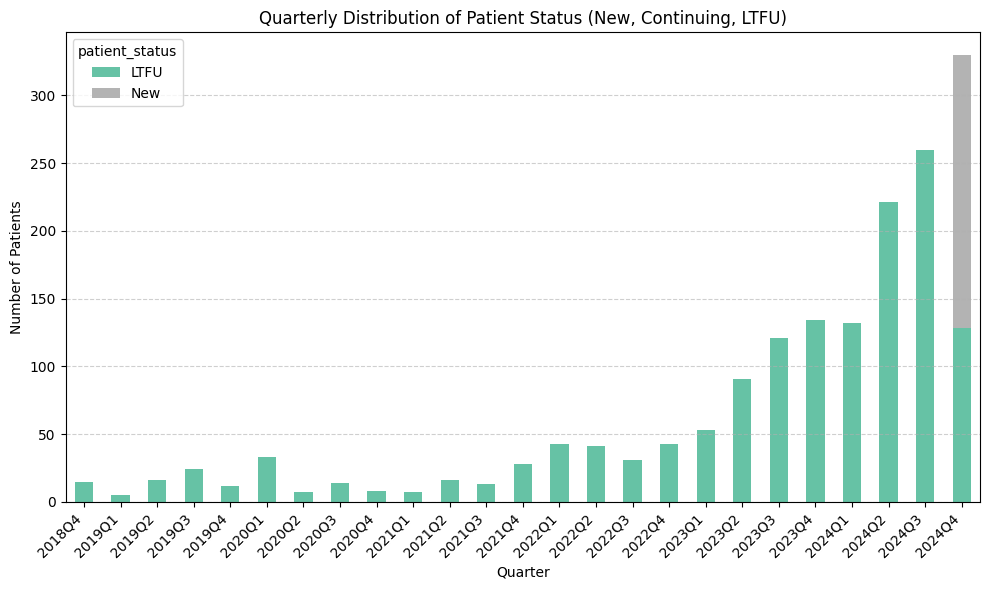

Figure saved as: quarterly_patient_status.png in: drive/MyDrive/Rulinga II/plots


In [ ]:
# -------------------------------------------------------------
# Patient Status Distribution — Cleaned and Readable Version
# -------------------------------------------------------------
# Purpose:
#   - Remove timestamps from date column
#   - Aggregate to quarterly or yearly for better readability
#   - Rotate and align x-labels for clarity
# -------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------------------------------------------
# Step 1. Load and clean dataset
# -------------------------------------------------------------
monthly_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv"
plot_dir = "drive/MyDrive/Rulinga II/plots"
os.makedirs(plot_dir, exist_ok=True)

monthly_df = pd.read_csv(monthly_path)

# Ensure proper datetime conversion
monthly_df['month'] = pd.to_datetime(monthly_df['month'], errors='coerce')

# Strip hours (00:00:00)
monthly_df['month'] = monthly_df['month'].dt.to_period('M').dt.to_timestamp()

# -------------------------------------------------------------
# Step 2. Compute patient status (New, Continuing, LTFU)
# -------------------------------------------------------------
monthly_df = monthly_df.sort_values(['OPIP_CODE', 'month'])
monthly_df['first_month'] = monthly_df.groupby('OPIP_CODE')['month'].transform('min')

monthly_df['patient_status'] = 'Continuing'
monthly_df.loc[monthly_df['month'] == monthly_df['first_month'], 'patient_status'] = 'New'
if 'LTFU' in monthly_df.columns:
    monthly_df.loc[monthly_df['LTFU'] == 1, 'patient_status'] = 'LTFU'

# -------------------------------------------------------------
# Step 3. Aggregate by quarter for clarity
# -------------------------------------------------------------
monthly_df['quarter'] = monthly_df['month'].dt.to_period('Q').astype(str)

status_counts = (
    monthly_df.groupby(['quarter', 'patient_status'])['OPIP_CODE']
    .nunique()
    .reset_index()
)

# Pivot for stacked plotting
status_pivot = status_counts.pivot(
    index='quarter', columns='patient_status', values='OPIP_CODE'
).fillna(0)

# -------------------------------------------------------------
# Step 4. Plot — Clean Quarterly Stacked Bar Chart
# -------------------------------------------------------------
plt.figure(figsize=(10, 6))
status_pivot.plot(kind='bar', stacked=True, colormap='Set2', ax=plt.gca())

plt.title('Quarterly Distribution of Patient Status (New, Continuing, LTFU)', fontsize=12)
plt.xlabel('Quarter')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig(f"{plot_dir}/quarterly_patient_status.png", dpi=300)
plt.show()

print("Figure saved as: quarterly_patient_status.png in:", plot_dir)



Annual Hepatitis B Incidence Rates (per 1,000 Patients):
 Year  New_Patients  Cumulative_Patients  Incidence_Rate
 2018            15                   15         1000.00
 2019            57                   72          791.67
 2020            62                  134          462.69
 2021            64                  198          323.23
 2022           158                  356          443.82
 2023           399                  755          528.48
 2024           943                 1698          555.36


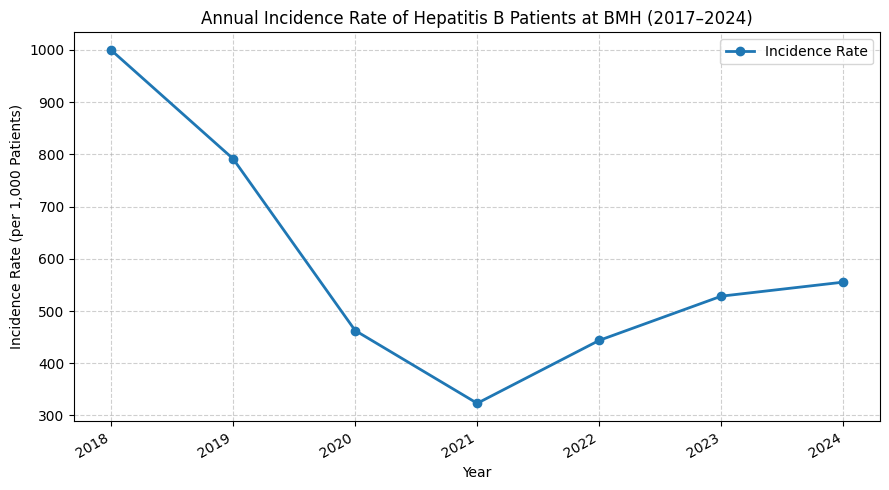


Figure saved to: drive/MyDrive/Rulinga II/plots/annual_incidence_rate.png


In [ ]:
# -------------------------------------------------------------
# Annual Incidence Rate Analysis for Hepatitis B Patients at BMH
# -------------------------------------------------------------
# Purpose
#   Compute and visualise yearly incidence rates of Hepatitis B
#   patients between 2017–2024 using cleaned registration data.
# -------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load data ---
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_final.csv")

# --- Parse and clean registration dates ---
df['REGN_DT'] = pd.to_datetime(df['REGN_DT'], errors='coerce')
df = df.dropna(subset=['REGN_DT'])

# --- Extract year ---
df['Year'] = df['REGN_DT'].dt.year

# --- Filter relevant years ---
df = df[(df['Year'] >= 2017) & (df['Year'] <= 2024)]

# --- Compute annual new patient counts ---
annual_counts = df.groupby('Year')['OPIP_CODE'].nunique().reset_index()
annual_counts.rename(columns={'OPIP_CODE': 'New_Patients'}, inplace=True)

# --- Compute cumulative patients and incidence rate ---
annual_counts['Cumulative_Patients'] = annual_counts['New_Patients'].cumsum()
annual_counts['Incidence_Rate'] = (
    annual_counts['New_Patients'] / annual_counts['Cumulative_Patients'] * 1000
).round(2)

# --- Print the summary table ---
print("\nAnnual Hepatitis B Incidence Rates (per 1,000 Patients):")
print(annual_counts.to_string(index=False))

# --- Plot incidence rate trend ---
plt.figure(figsize=(9, 5))
plt.plot(
    annual_counts['Year'],
    annual_counts['Incidence_Rate'],
    marker='o',
    linewidth=2,
    label='Incidence Rate'
)
plt.title("Annual Incidence Rate of Hepatitis B Patients at BMH (2017–2024)", fontsize=12)
plt.xlabel("Year")
plt.ylabel("Incidence Rate (per 1,000 Patients)")
plt.xticks(annual_counts['Year'], rotation=30, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# --- Save and display ---
plt.savefig("drive/MyDrive/Rulinga II/plots/annual_incidence_rate.png", dpi=300)
plt.show()

print("\nFigure saved to: drive/MyDrive/Rulinga II/plots/annual_incidence_rate.png")




1.   Seasonal trend (June–October peaks)
2.   Gender and age distribution




Monthly Distribution of Hepatitis B Patients
Month  Patient_Count  Percentage (%)
  Jan             93             5.5
  Feb            103             6.1
  Mar             77             4.5
  Apr            101             5.9
  May            153             9.0
  Jun            138             8.1
  Jul            174            10.2
  Aug            149             8.8
  Sep            140             8.2
  Oct            206            12.1
  Nov            148             8.7
  Dec            216            12.7


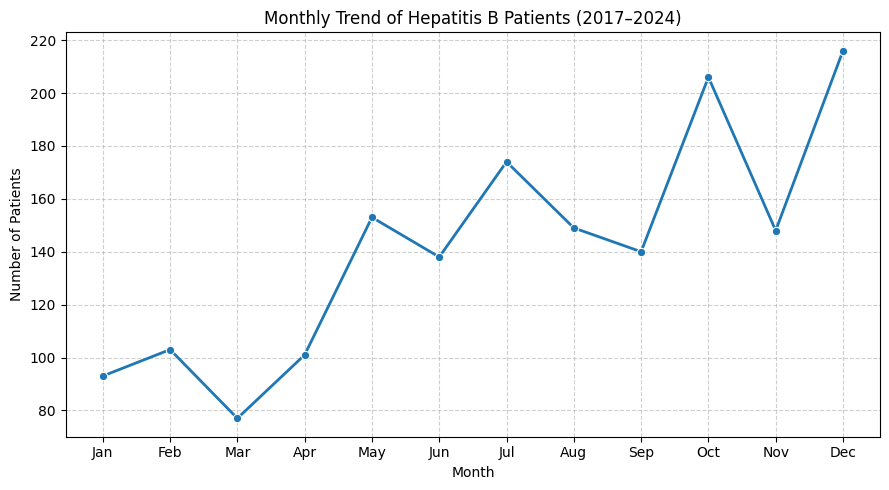


Gender Distribution Summary:
 Count  count  Percentage (%)
   NaN   1051             NaN
   NaN    659             NaN


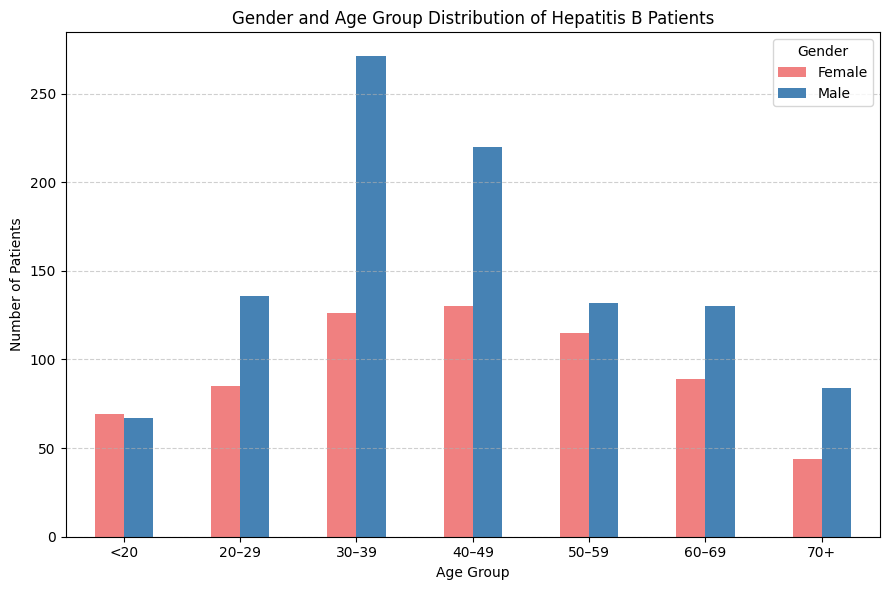


 Figures and tables generated successfully.
 - Table 4.1C: Monthly Distribution of Hepatitis B Patients
 - Figure 4.4: drive/MyDrive/Rulinga II/plots/Monthly_Seasonality.png
 - Figure 4.4A: drive/MyDrive/Rulinga II/plots/Gender_Age_Distribution.png


In [ ]:
# -------------------------------------------------------------
# Hepatitis B Seasonality, Gender and Age Distribution Analysis
# -------------------------------------------------------------

# Purpose:
#   - Generate Table and Figures
#   - Verify seasonal variation (June–October)
#   - Show gender and age distribution patterns
# -------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------------------------------------------
# Step 1. Load and clean data
# -------------------------------------------------------------
data_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_final.csv"
plot_dir = "drive/MyDrive/Rulinga II/plots"
os.makedirs(plot_dir, exist_ok=True)

# Load data
df = pd.read_csv(data_path)
df['REGN_DT'] = pd.to_datetime(df['REGN_DT'], errors='coerce')
df = df.dropna(subset=['REGN_DT'])

# Extract month and year for analysis
df['year'] = df['REGN_DT'].dt.year
df['month'] = df['REGN_DT'].dt.month
df['month_name'] = df['REGN_DT'].dt.strftime('%b')

# -------------------------------------------------------------
# Step 2. Compute Monthly Distribution
# -------------------------------------------------------------
# Group and count unique patients by month
monthly_counts = (
    df.groupby('month_name')['OPIP_CODE']
    .nunique()
    .reindex(
        ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    )
    .reset_index()
)

monthly_counts.columns = ['Month', 'Patient_Count']

# --- Ensure numeric dtype ---
monthly_counts['Patient_Count'] = pd.to_numeric(monthly_counts['Patient_Count'], errors='coerce')

# Compute percentage distribution
monthly_counts['Percentage (%)'] = (
    monthly_counts['Patient_Count'] / monthly_counts['Patient_Count'].sum() * 100
).round(1)

print("\nMonthly Distribution of Hepatitis B Patients")
print(monthly_counts.to_string(index=False))

# -------------------------------------------------------------
# Step 3. Plot Monthly Seasonality
# -------------------------------------------------------------
plt.figure(figsize=(9, 5))
sns.lineplot(data=monthly_counts, x='Month', y='Patient_Count', marker='o', linewidth=2)
plt.title('Monthly Trend of Hepatitis B Patients (2017–2024)', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Number of Patients')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f"{plot_dir}/Monthly_Seasonality.png", dpi=300)
plt.show()

# -------------------------------------------------------------
# Step 4. Gender and Age Distribution
# -------------------------------------------------------------
# Convert gender numerics to labels
if df['GENDER'].dtype in ['int64', 'float64']:
    df['Gender_Label'] = df['GENDER'].map({1: 'Male', 2: 'Female'})
else:
    df['Gender_Label'] = df['GENDER'].astype(str)

# Gender summary
gender_counts = (
    df['Gender_Label']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Gender', 'Gender_Label': 'Count'})
)

# --- Ensure 'Count' is numeric before division ---
gender_counts['Count'] = pd.to_numeric(gender_counts['Count'], errors='coerce')

gender_counts['Percentage (%)'] = (
    gender_counts['Count'] / gender_counts['Count'].sum() * 100
).round(1)

print("\nGender Distribution Summary:")
print(gender_counts.to_string(index=False))

# -------------------------------------------------------------
# Step 5. Age Grouping and Gender–Age Distribution Plot
# -------------------------------------------------------------
bins = [0, 19, 29, 39, 49, 59, 69, 120]
labels = ['<20', '20–29', '30–39', '40–49', '50–59', '60–69', '70+']
df['Age_Group'] = pd.cut(df['AGE'], bins=bins, labels=labels, include_lowest=True)

# Cross-tabulate by gender and age group
age_gender = (
    df.groupby(['Age_Group', 'Gender_Label'], observed=True)['OPIP_CODE']
    .nunique()
    .unstack()
    .fillna(0)
)

# Reorder columns to ensure consistency
cols = [c for c in ['Female', 'Male'] if c in age_gender.columns]
age_gender = age_gender[cols]

# -------------------------------------------------------------
# Step 6. Plot Gender–Age Distribution
# -------------------------------------------------------------
plt.figure(figsize=(9, 6))
age_gender.plot(kind='bar', ax=plt.gca(), color=['lightcoral', 'steelblue'])
plt.title('Gender and Age Group Distribution of Hepatitis B Patients', fontsize=12)
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.legend(title='Gender')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f"{plot_dir}/Gender_Age_Distribution.png", dpi=300)
plt.show()

# -------------------------------------------------------------
# Step 7. Output Summary
# -------------------------------------------------------------
print("\n Figures and tables generated successfully.")
print(" - Table 4.1C: Monthly Distribution of Hepatitis B Patients")
print(f" - Figure 4.4: {plot_dir}/Monthly_Seasonality.png")
print(f" - Figure 4.4A: {plot_dir}/Gender_Age_Distribution.png")


### Individual Trajectories

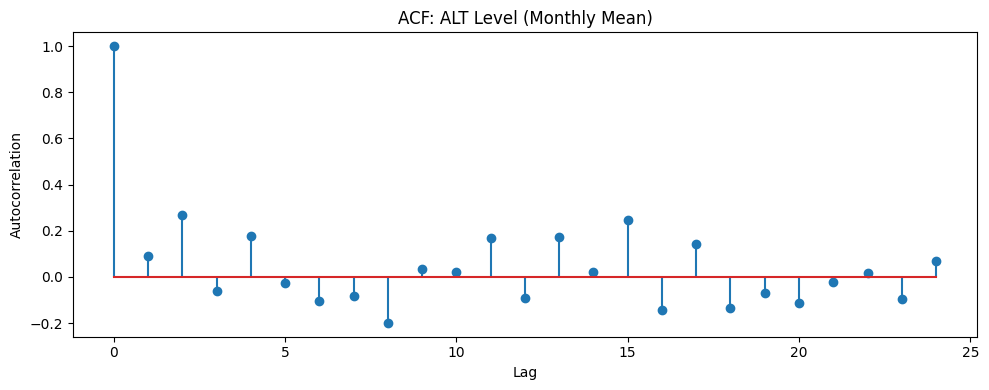

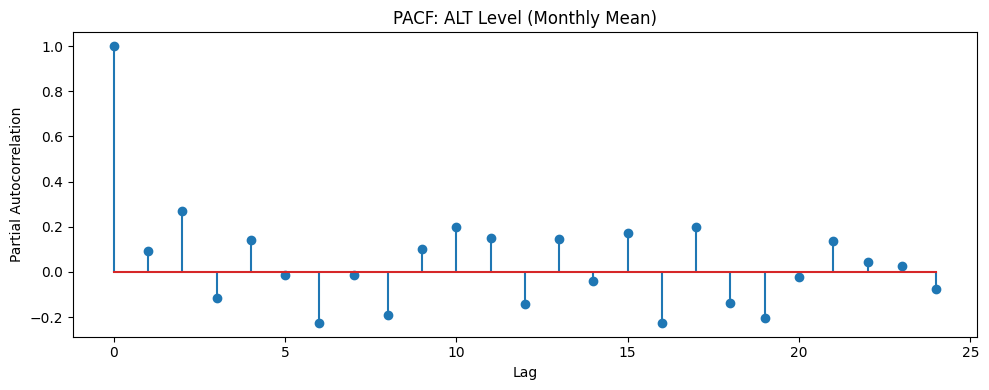

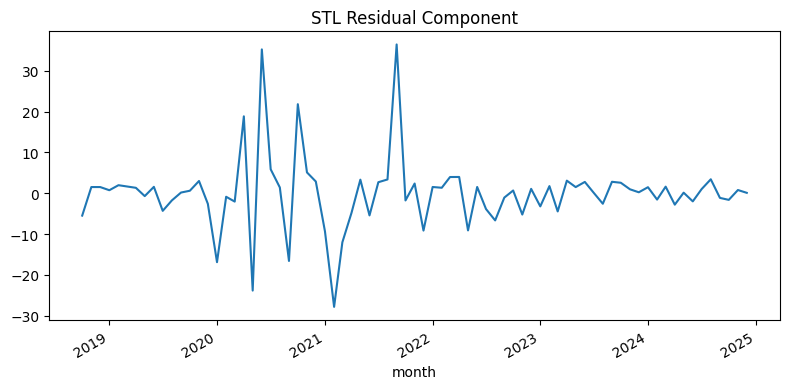

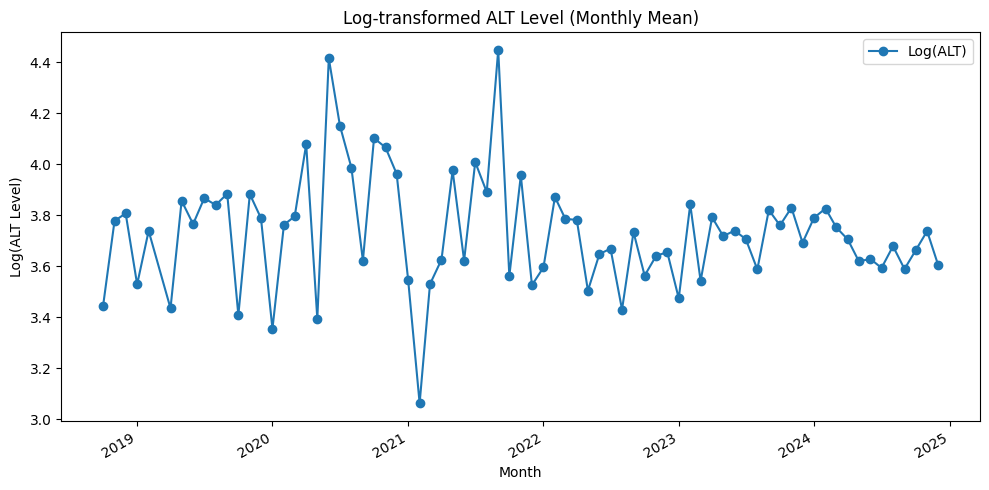

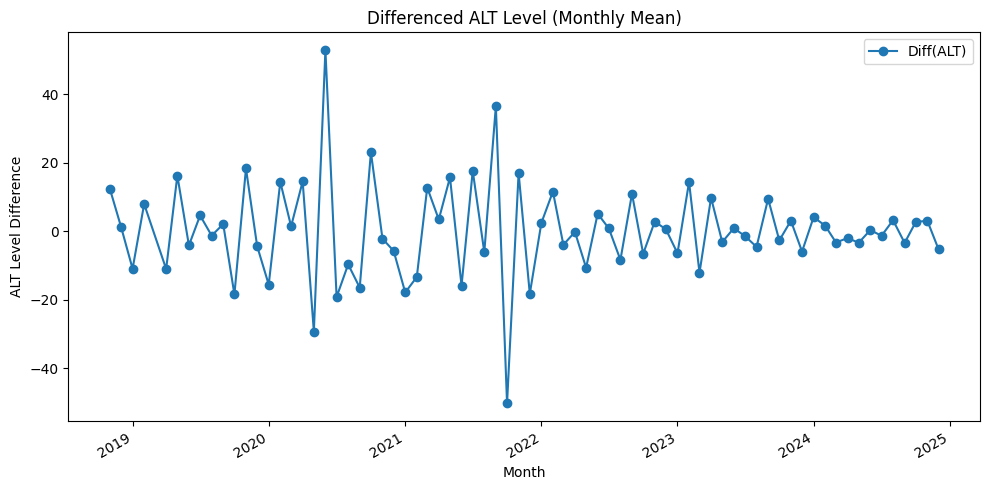

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL
import os

# Paths
monthly_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv"
plot_dir = "drive/MyDrive/Rulinga II/plots"
os.makedirs(plot_dir, exist_ok=True)

# 1. Load Data
df = pd.read_csv(monthly_path, parse_dates=['month'])

# --- Select patients with multiple time points ---
patient_counts = df['OPIP_CODE'].value_counts()
multi_visit_patients = patient_counts[patient_counts > 1].index.tolist()
df_multi = df[df['OPIP_CODE'].isin(multi_visit_patients)]

# Plot longitudinal ALT for first 5 patients with >1 time point
for pid in multi_visit_patients[:5]:
    sub = df_multi[df_multi['OPIP_CODE'] == pid].sort_values('month')
    plt.figure(figsize=(8,5))
    plt.plot(sub['month'], sub['ALT_LEVEL'], marker='o', label=f'ALT for {pid}')
    plt.title(f'ALT Trajectory: Patient {pid}')
    plt.xlabel('Month')
    plt.ylabel('ALT Level')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/alt_trajectory_patient_{pid}.png")
    plt.close()
    # plt.show() # Added plt.show() to display plots in Colab

# --- Time Series Analysis for ALT (overall average monthly ALT) ---
alt_series = df.groupby('month')['ALT_LEVEL'].mean().dropna()

# -- Transformations --
alt_log = np.log1p(alt_series)
alt_diff = alt_series.diff().dropna()

# --- Seasonality & Stationarity ---
# ADF Test (stationarity)
adf_result = adfuller(alt_series)
with open("drive/MyDrive/Rulinga II/adf_test_alt.txt", "w") as f:
    f.write(f"ADF Statistic: {adf_result[0]}\n")
    f.write(f"p-value: {adf_result[1]}\n")
    f.write(f"Lags Used: {adf_result[2]}\n")
    f.write(f"Observations: {adf_result[3]}\n")
    f.write(f"Critical Values: {adf_result[4]}\n")
    f.write(f"Stationary: {'Yes' if adf_result[1]<0.05 else 'No'}\n")

# ACF/PACF
plt.figure(figsize=(10,4))
plt.stem(acf(alt_series, nlags=24)) # Removed use_line_collection=True
plt.title('ACF: ALT Level (Monthly Mean)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.savefig(f"{plot_dir}/acf_alt.png")
# plt.close()
plt.show() # Added plt.show() to display plots in Colab

plt.figure(figsize=(10,4))
plt.stem(pacf(alt_series, nlags=24)) # Removed use_line_collection=True
plt.title('PACF: ALT Level (Monthly Mean)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.savefig(f"{plot_dir}/pacf_alt.png")
# plt.close()
plt.show() # Added plt.show() to display plots in Colab

# STL Decomposition
stl = STL(alt_series, period=12, robust=True)
res = stl.fit()
res.seasonal.plot(title="STL Seasonal Component", figsize=(8,4))
plt.tight_layout()
plt.savefig(f"{plot_dir}/stl_seasonal_alt.png")
plt.close()
res.trend.plot(title="STL Trend Component", figsize=(8,4))
plt.tight_layout()
plt.savefig(f"{plot_dir}/stl_trend_alt.png")
plt.close()
res.resid.plot(title="STL Residual Component", figsize=(8,4))
plt.tight_layout()
plt.savefig(f"{plot_dir}/stl_resid_alt.png")
# plt.close()
plt.show() # Added plt.show() to display plots in Colab

# --- Transformed time series plots ---
plt.figure(figsize=(10,5))
alt_log.plot(label='Log(ALT)', marker='o')
plt.title('Log-transformed ALT Level (Monthly Mean)')
plt.xlabel('Month')
plt.ylabel('Log(ALT Level)')
plt.legend()
plt.tight_layout()
plt.savefig(f"{plot_dir}/log_alt_monthly.png")
# plt.close()
plt.show() # Added plt.show() to display plots in Colab

plt.figure(figsize=(10,5))
alt_diff.plot(label='Diff(ALT)', marker='o')
plt.title('Differenced ALT Level (Monthly Mean)')
plt.xlabel('Month')
plt.ylabel('ALT Level Difference')
plt.legend()
plt.tight_layout()
plt.savefig(f"{plot_dir}/diff_alt_monthly.png")
# plt.close()
plt.show() # Added plt.show() to display plots in Colab


# print("Individual trajectories, seasonality, stationarity, and transformations complete. Plots and ADF result saved.")

## Feature Engineering


### Temporal Features

In [ ]:
import pandas as pd
import numpy as np

# Load monthly long-form data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])

# Sort for lag calculations
df = df.sort_values(['OPIP_CODE', 'month'])

# --- Lagged Features (1, 3, 6 months) ---
for lag in [1, 3, 6]:
    df[f'ALT_LEVEL_lag{lag}'] = df.groupby('OPIP_CODE')['ALT_LEVEL'].shift(lag)
    df[f'VIRAL_LOAD_lag{lag}'] = df.groupby('OPIP_CODE')['VIRAL_LOAD'].shift(lag)

# --- Moving Averages (1, 3, 6 months windows) ---
for window in [1, 3, 6]:
    df[f'ALT_LEVEL_ma{window}'] = df.groupby('OPIP_CODE')['ALT_LEVEL'].rolling(window, min_periods=1).mean().reset_index(level=0, drop=True)
    df[f'VIRAL_LOAD_ma{window}'] = df.groupby('OPIP_CODE')['VIRAL_LOAD'].rolling(window, min_periods=1).mean().reset_index(level=0, drop=True)

# --- Calendar Variables ---
df['month_num'] = df['month'].dt.month
df['year'] = df['month'].dt.year
df['quarter'] = df['month'].dt.quarter

# --- Time Since First Visit ---
df['first_month'] = df.groupby('OPIP_CODE')['month'].transform('min')
# Calculate months since first visit more accurately
df['months_since_first'] = (df['year'] - df['first_month'].dt.year) * 12 + (df['month_num'] - df['first_month'].dt.month)


# --- Number of Visits ---
df['visit_count'] = df.groupby('OPIP_CODE').cumcount() + 1

# Save the enriched dataset
df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_temporal.csv", index=False)
print("Temporal feature engineering complete. Output saved as DIAGNOSIS_RESULTS_monthly_temporal.csv")

Temporal feature engineering complete. Output saved as DIAGNOSIS_RESULTS_monthly_temporal.csv


### Patient-Level Features
- **Static:** Sex, age at diagnosis, baseline ALT/viral load.
- **Time-varying:** Monthly ALT, viral load, treatment start, etc.


In [ ]:
import pandas as pd
import numpy as np

# Load monthly long-form data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])

# ---- Static Patient-Level Features ----
# Sex, age at diagnosis, baseline ALT/viral load (first observed per patient)
df_static = df.sort_values(['OPIP_CODE', 'month']).groupby('OPIP_CODE').first().reset_index()

# Make a copy before renaming columns
df_static_features = df_static[['OPIP_CODE', 'GENDER', 'AGE', 'ALT_LEVEL', 'VIRAL_LOAD']].copy()
df_static_features = df_static_features.rename(columns={
    'GENDER': 'sex',
    'AGE': 'age_at_diagnosis',
    'ALT_LEVEL': 'baseline_ALT',
    'VIRAL_LOAD': 'baseline_viral_load'
})

df_static_features.to_csv("drive/MyDrive/Rulinga II/patient_static_features.csv", index=False)

# ---- Time-Varying Patient-Level Features ----
# Monthly ALT, viral load, placeholder for treatment start (add if available)
cols = ['OPIP_CODE', 'month', 'ALT_LEVEL', 'VIRAL_LOAD', 'VIRAL_LOAD_LOG']
if 'TREATMENT_START' in df.columns:
    cols.append('TREATMENT_START')
df_timevarying_features = df[cols].copy()

df_timevarying_features.to_csv("drive/MyDrive/Rulinga II/patient_timevarying_features.csv", index=False)

print("Static and time-varying patient-level features saved as CSVs")

Static and time-varying patient-level features saved as CSVs


### Survival & Censoring Features
- **Censoring Indicator:** For LTFU.
- **Survival-like Features:** Time-at-risk, event indicators.
- **Dropout Predictors:** Create features indicating risk of dropout and time to dropout.


In [ ]:
import pandas as pd
import numpy as np

# Load monthly long-form data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])

# Sort for proper groupby calculations
df = df.sort_values(['OPIP_CODE', 'month'])

# ---- Censoring Indicator: LTFU ----
# Assume 'LTFU' column exists (1 for lost to follow-up, else 0)
df['censored'] = df['LTFU'].astype(int)

# ---- Survival-like Features: time-at-risk, event indicators ----
# Time-at-risk: months since first visit
df['first_month'] = df.groupby('OPIP_CODE')['month'].transform('min')
# Calculate months since first visit more accurately
df['time_at_risk'] = (df['month'].dt.year - df['first_month'].dt.year) * 12 + (df['month'].dt.month - df['first_month'].dt.month)

# Event indicator: 1 if patient dropped out (LTFU) in this time period, else 0
# This needs refinement based on how LTFU is defined - currently assumes LTFU is marked at the last visit.
# A more accurate event indicator would require knowing the *exact* time of dropout relative to visits.
df['event'] = df['LTFU'].astype(int)  # Assuming LTFU is marked at dropout timepoint

# ---- Dropout Predictors ----
# Time to dropout: months until LTFU (NaN if not LTFU)
df['last_month'] = df.groupby('OPIP_CODE')['month'].transform('max')
# Calculate dropout time in months accurately
df['dropout_time'] = np.where(
    df['LTFU'] == 1,
    (df['month'].dt.year - df['first_month'].dt.year) * 12 + (df['month'].dt.month - df['first_month'].dt.month),
    np.nan
)


# Risk features (example: high ALT or viral load)
df['high_ALT'] = (df['ALT_LEVEL'] > 40).astype(int)  # Example threshold, adjust as needed
df['high_VL'] = (df['VIRAL_LOAD'] > 2000).astype(int)  # Example threshold, adjust as needed

# Rolling risk: was ALT or VL high in last 3 months?
df['high_ALT_last3'] = df.groupby('OPIP_CODE')['high_ALT'].rolling(3, min_periods=1).max().reset_index(level=0, drop=True)
df['high_VL_last3'] = df.groupby('OPIP_CODE')['high_VL'].rolling(3, min_periods=1).max().reset_index(level=0, drop=True)

# Save survival and censoring features
df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_survival.csv", index=False)
print("Survival and censoring features saved in DIAGNOSIS_RESULTS_monthly_survival.csv")

Survival and censoring features saved in DIAGNOSIS_RESULTS_monthly_survival.csv


### **Combine the static, time-varying, and survival features**

In [ ]:
import pandas as pd

# Load the feature datasets
static_features = pd.read_csv("drive/MyDrive/Rulinga II/patient_static_features.csv")
timevarying_features = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_temporal.csv", parse_dates=['month'])
survival_features = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_survival.csv", parse_dates=['month'])

# Merge time-varying and survival features first (they share OPIP_CODE and month)
combined_df = pd.merge(timevarying_features, survival_features, on=['OPIP_CODE', 'month'], how='left', suffixes=('_temp', '_surv'))

# Handle potential duplicate columns from suffixes if any (usually not needed if columns are distinct)
# If there are duplicate columns with _temp and _surv suffixes, decide which one to keep or how to combine.
# For this case, it's likely the columns are the same, so drop the duplicated ones.
for col in combined_df.columns:
    if col.endswith('_surv'):
        base_col = col.replace('_surv', '')
        if base_col in combined_df.columns.str.replace('_temp', ''):
            # Assuming the data in these columns should be identical, drop the suffixed one
            combined_df.drop(columns=[col], inplace=True)
        elif base_col + '_temp' in combined_df.columns:
             combined_df.drop(columns=[col], inplace=True)

# Merge with static features (only shares OPIP_CODE)
# Use a left merge to keep all rows from the combined time-varying/survival data
final_df = pd.merge(combined_df, static_features, on='OPIP_CODE', how='left')

# Save the final combined dataset
final_df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_combined_features.csv", index=False)

print("Combined feature dataset saved as DIAGNOSIS_RESULTS_combined_features.csv")
display(final_df.head())

Combined feature dataset saved as DIAGNOSIS_RESULTS_combined_features.csv


,OPIP_CODE,month,UHID_temp,GENDER_temp,AGE_temp,VIRAL_LOAD_temp,ALT_LEVEL_temp,VIRAL_LOAD_LOG_temp,LTFU_temp,ALT_LEVEL_lag1,...,last_month,dropout_time,high_ALT,high_VL,high_ALT_last3,high_VL_last3,sex,age_at_diagnosis,baseline_ALT,baseline_viral_load
0,IB18000833,2018-11-01,BM00004114,1,30,9817.3,44.8,9.192003,True,NaN,...,2018-11-01,0.0,1,1,1.0,1.0,1,30,44.8,9817.3
1,IB18000870,2018-11-01,BM00004276,1,45,20924.6,79.2,9.948729,True,NaN,...,2018-11-01,0.0,1,1,1.0,1.0,1,45,79.2,20924.6
2,IB18001023,2018-11-01,BM00005140,1,48,15594.0,20.5,9.654706,True,NaN,...,2018-11-01,0.0,0,1,0.0,1.0,1,48,20.5,15594.0
3,IB19005210,2019-11-01,1934-03-20 00:00:00,1,21,8309.0,38.2,9.025215,True,NaN,...,2019-11-01,0.0,0,1,0.0,1.0,1,21,38.2,8309.0
4,IB21002687,2021-04-01,BM00076917,1,58,7110.0,12.9,8.869398,True,NaN,...,2021-04-01,0.0,0,1,0.0,1.0,1,58,12.9,7110.0


### Handling Missing Data


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# Load monthly long-form data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])

# --- 1. Masking: Binary masks for missing time points ---
df['mask_ALT_LEVEL'] = (~df['ALT_LEVEL'].isna()).astype(int)
df['mask_VIRAL_LOAD'] = (~df['VIRAL_LOAD'].isna()).astype(int)

# --- 2. Dropout indicators as features ---
# Assuming 'LTFU' column exists and is 1 for lost to follow-up
df['dropout_indicator'] = df['LTFU'].astype(int)

# --- 3. Inverse Probability Weighting (IPW) for MNAR bias ---
# Estimate dropout probability via logistic regression
# Use baseline and time-varying features for prediction
feature_cols = ['AGE', 'GENDER', 'ALT_LEVEL', 'VIRAL_LOAD']  # Add more if available

# Prepare data for dropout prediction (use only the last record per patient for LTFU status)
df_last = df.sort_values(['OPIP_CODE', 'month']).groupby('OPIP_CODE').last().reset_index()
X = df_last[feature_cols].fillna(df_last[feature_cols].mean())
y = df_last['dropout_indicator']

# Logistic regression for dropout probability (IPW)
model = LogisticRegression(max_iter=1000)
model.fit(X, y)
dropout_prob = model.predict_proba(X)[:,1]
ipw = 1.0 / np.clip(dropout_prob, 0.01, 0.99)  # Avoid division by zero/extremes

# Merge IPW weights back to the full data
df_last['ipw'] = ipw
df = df.merge(df_last[['OPIP_CODE', 'ipw']], on='OPIP_CODE', how='left')

# Save ML-ready dataset
df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_ml_missing.csv", index=False)
print("Missing data features (masks, dropout indicators, IPW) saved for ML models.")

Missing data features (masks, dropout indicators, IPW) saved for ML models.


### Sequence Modelling


In [ ]:
import pandas as pd
import numpy as np

# Load the combined feature dataset
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_combined_features.csv", parse_dates=['month'])

# Sort for sequence ordering
df = df.sort_values(['OPIP_CODE', 'month'])

# --- Parameters for sequence length ---
SEQ_LEN = 12  # e.g., 12 months (can set to 24 or other)

# --- Format as sequences for deep learning (one sequence per patient) ---
# Exclude columns that are not in the combined dataset or are not intended for sequences
feature_cols = [
    'ALT_LEVEL_temp', 'VIRAL_LOAD_temp', 'VIRAL_LOAD_LOG_temp',
    'ALT_LEVEL_lag1', 'ALT_LEVEL_lag3', 'ALT_LEVEL_lag6',
    'VIRAL_LOAD_lag1', 'VIRAL_LOAD_lag3', 'VIRAL_LOAD_lag6',
    'ALT_LEVEL_ma1', 'ALT_LEVEL_ma3', 'ALT_LEVEL_ma6',
    'VIRAL_LOAD_ma1', 'VIRAL_LOAD_ma3', 'VIRAL_LOAD_ma6',
    # Removed mask_ALT_LEVEL, mask_VIRAL_LOAD, dropout_indicator as they are not in the combined dataset
]

sequences = []
patient_ids = []
for pid, group in df.groupby('OPIP_CODE'):
    group = group.sort_values('month')
    seq = group[feature_cols].values
    # Pad or truncate to SEQ_LEN
    if len(seq) < SEQ_LEN:
        pad = np.zeros((SEQ_LEN - len(seq), len(feature_cols)))
        seq = np.vstack([seq, pad])
    elif len(seq) > SEQ_LEN:
        seq = seq[:SEQ_LEN]
    sequences.append(seq)
    patient_ids.append(pid)

# Convert to arrays for ML frameworks
sequences = np.array(sequences)  # shape: (num_patients, SEQ_LEN, num_features)
patient_ids = np.array(patient_ids)

# --- Save as .npz for deep learning use ---
np.savez("drive/MyDrive/Rulinga II/patient_sequences.npz",
         sequences=sequences, patient_ids=patient_ids, feature_cols=feature_cols)

print(f"Saved {len(sequences)} patient sequences (length {SEQ_LEN}) to patient_sequences.npz.")

# --- Note: In our data loader/model code ---
# If masks or dropout indicators are needed, they would need to be handled separately
# or included in the combined feature dataset creation step.
# Adjust SEQ_LEN as needed for your model.

Saved 1698 patient sequences (length 12) to patient_sequences.npz.


## Data Splitting


In [ ]:
import pandas as pd
import numpy as np

# Load monthly temporal data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_temporal.csv", parse_dates=['month'])

# --- Assign years for split ---
df['year'] = df['month'].dt.year

# --- Patient-level split for trajectory integrity ---
# Find each patient's first year of observation
patient_years = df.groupby('OPIP_CODE')['year'].min().reset_index()
patient_years['set'] = np.where(patient_years['year'] <= 2022, 'train', 'test')

# Merge set assignment back to full data
df = df.merge(patient_years[['OPIP_CODE', 'set']], on='OPIP_CODE', how='left')

train_df = df[df['set'] == 'train']
test_df = df[df['set'] == 'test']

# --- Save splits ---
train_df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_train.csv", index=False)
test_df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_test.csv", index=False)

print(f"Time-aware split complete:\nTrain patients: {train_df['OPIP_CODE'].nunique()}\nTest patients: {test_df['OPIP_CODE'].nunique()}")
print("Train and test CSVs saved.")

Time-aware split complete:
Train patients: 356
Test patients: 1342
Train and test CSVs saved.


### Cross-Validation
- Time-series CV (rolling or expanding window).


In [ ]:
import pandas as pd
import numpy as np

# Load monthly temporal data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_temporal.csv", parse_dates=['month'])

# Ensure patient trajectory integrity
df = df.sort_values(['OPIP_CODE', 'month'])

# Parameters for time-series cross-validation
start_year = 2017
end_year = 2024
window_size = 3  # years in train window
test_size = 1    # years in test window

splits = []
for train_end in range(start_year + window_size, end_year + 1 - test_size):
    train_start = train_end - window_size
    test_start = train_end
    test_end = train_end + test_size

    # Select train/test patients based on first observation
    patient_years = df.groupby('OPIP_CODE')['month'].min().dt.year
    train_patients = patient_years[(patient_years >= train_start) & (patient_years < train_end)].index
    test_patients = patient_years[(patient_years >= test_start) & (patient_years < test_end)].index

    train_df = df[df['OPIP_CODE'].isin(train_patients)]
    test_df = df[df['OPIP_CODE'].isin(test_patients)]
    splits.append({
        'train_start': train_start,
        'train_end': train_end,
        'test_start': test_start,
        'test_end': test_end,
        'train_patients': len(train_patients),
        'test_patients': len(test_patients)
    })

    # Optionally save each split
    train_df.to_csv(f"drive/MyDrive/Rulinga II/tscv_train_{train_start}_{train_end}.csv", index=False)
    test_df.to_csv(f"drive/MyDrive/Rulinga II/tscv_test_{test_start}_{test_end}.csv", index=False)

# Save summary of splits
pd.DataFrame(splits).to_csv("drive/MyDrive/Rulinga II/time_series_cv_splits.csv", index=False)

print("Time-series cross-validation complete. Rolling/expanding windows saved, summary available.")

Time-series cross-validation complete. Rolling/expanding windows saved, summary available.


## Model Training and Development

In [ ]:
import pandas as pd

# Load your monthly or yearly dataframe
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])

# Compute number of patients per month
monthly_counts = df.groupby('month')['OPIP_CODE'].nunique().reset_index()
monthly_counts.rename(columns={'OPIP_CODE': 'patient_count'}, inplace=True)

# Now 'patient_count' exists:
print(monthly_counts.head())

       month  patient_count
0 2018-10-01              5
1 2018-11-01              7
2 2018-12-01              3
3 2019-01-01              3
4 2019-02-01              2


Loading monthly datasets...

Training XGBoost...

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train set: 1358, number of used features: 11
[LightGBM] [Info] Start training from score 49.421208

Training Linear Regression...

Preparing sequential data for LSTM...

Building and training tuned LSTM model...
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 3696.3481 - mae: 49.4628 - val_loss: 5960.0195 - val_mae: 75.8342
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 1249.3105 - mae: 29.4179 - val_loss: 4273.7837 - val_mae: 64.5448
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1052.4791 - mae: 27.0633 - val_loss: 1670.0463 - val_mae: 38.1557
Epoch 4/100
50/50 ━━━━━━━━━━━━━━

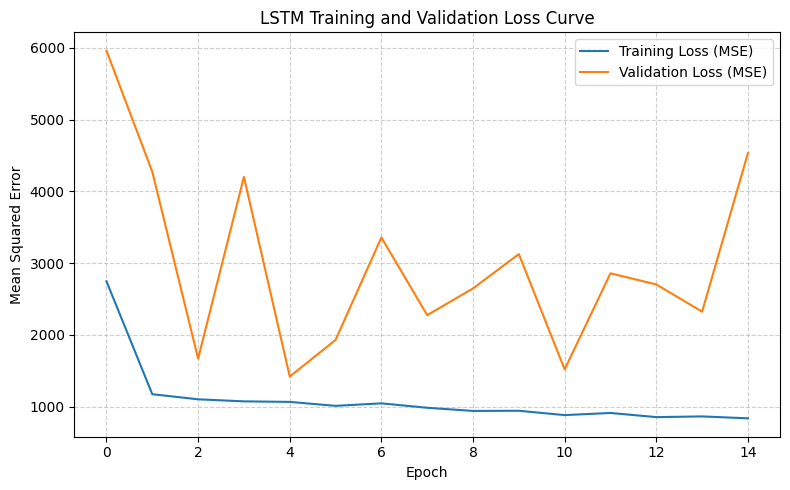


Model training complete and models saved:
 - XGBoost: drive/MyDrive/Rulinga II/xgb_model.pkl
 - LightGBM: drive/MyDrive/Rulinga II/lgb_model.pkl
 - Linear Regression: drive/MyDrive/Rulinga II/lr_model.pkl
 - Tuned LSTM: drive/MyDrive/Rulinga II/lstm_tuned_model.h5


In [ ]:
# -------------------------------------------------------------
# Hepatitis B Monthly Model Training (Based on Provided Pipeline)
# -------------------------------------------------------------

# Purpose:
#   - Train XGBoost, LightGBM, Linear Regression, and Enhanced LSTM
#   - Based on merged monthly dataset with lag and missingness features
# -------------------------------------------------------------

import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# -------------------------------------------------------------
# Step 1: Load and Merge Datasets
# -------------------------------------------------------------
print("Loading monthly datasets...")

df_long = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])
monthly_counts = df_long.groupby('month')['OPIP_CODE'].nunique().reset_index()
monthly_counts.rename(columns={'OPIP_CODE': 'patient_count'}, inplace=True)

df_feat = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_temporal.csv", parse_dates=['month'])
df_feat = df_feat.merge(monthly_counts, on='month', how='left')

df_missing_features = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_ml_missing.csv", parse_dates=['month'])
df_feat = df_feat.merge(
    df_missing_features[['OPIP_CODE', 'month', 'mask_ALT_LEVEL', 'mask_VIRAL_LOAD', 'dropout_indicator', 'ipw']],
    on=['OPIP_CODE', 'month'], how='left'
)

# -------------------------------------------------------------
# Step 2: Prepare Tabular Data
# -------------------------------------------------------------
feature_cols = [
    'ALT_LEVEL', 'VIRAL_LOAD', 'ALT_LEVEL_lag1', 'ALT_LEVEL_lag3', 'ALT_LEVEL_lag6',
    'VIRAL_LOAD_lag1', 'VIRAL_LOAD_lag3', 'VIRAL_LOAD_lag6',
    'ALT_LEVEL_ma1', 'ALT_LEVEL_ma3', 'ALT_LEVEL_ma6',
    'VIRAL_LOAD_ma1', 'VIRAL_LOAD_ma3', 'VIRAL_LOAD_ma6',
    'mask_ALT_LEVEL', 'mask_VIRAL_LOAD', 'dropout_indicator', 'AGE', 'GENDER'
]
target_col = 'patient_count'

df_train_tab = df_feat.dropna(subset=[target_col])
X_tab = df_train_tab[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
y_tab = df_train_tab[target_col].replace([np.inf, -np.inf], np.nan).fillna(0)

# Split data for training/testing
X_train_tab, X_test_tab, y_train_tab, y_test_tab = train_test_split(X_tab, y_tab, test_size=0.2, shuffle=False)

# -------------------------------------------------------------
# Step 3: Train Machine Learning Models
# -------------------------------------------------------------
print("\nTraining XGBoost...")
xgb_model = xgb.XGBRegressor(max_depth=6, learning_rate=0.05, n_estimators=300, subsample=0.8, random_state=42)
xgb_model.fit(X_train_tab, y_train_tab)
joblib.dump(xgb_model, "drive/MyDrive/Rulinga II/xgb_model.pkl")

print("\nTraining LightGBM...")
lgb_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=300, boosting_type='gbdt', random_state=42)
lgb_model.fit(X_train_tab, y_train_tab)
joblib.dump(lgb_model, "drive/MyDrive/Rulinga II/lgb_model.pkl")

print("\nTraining Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_tab, y_train_tab)
joblib.dump(lr_model, "drive/MyDrive/Rulinga II/lr_model.pkl")

# -------------------------------------------------------------
# Step 4: Prepare Data for LSTM
# -------------------------------------------------------------
print("\nPreparing sequential data for LSTM...")

# Normalise features for neural network
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X_tab)

# Create supervised sequences (time_steps = 12 months)
time_steps = 12
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(pd.DataFrame(scaled_features), y_tab, time_steps)
X_train_seq, X_val_seq = X_seq[:-100], X_seq[-100:]
y_train_seq, y_val_seq = y_seq[:-100], y_seq[-100:]

# -------------------------------------------------------------
# Step 5: Build and Train Tuned LSTM Model
# -------------------------------------------------------------
print("\nBuilding and training tuned LSTM model...")

model_lstm = models.Sequential([
    layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    layers.Dropout(0.2),
    layers.LSTM(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

optimizer = optimizers.Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

model_lstm.save("drive/MyDrive/Rulinga II/lstm_tuned_model.keras")

# -------------------------------------------------------------
# Step 6: Plot LSTM Loss Curve
# -------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('LSTM Training and Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("drive/MyDrive/Rulinga II/plots/LSTM_Loss_Curve.png", dpi=300)
plt.show()

# -------------------------------------------------------------
# Step 7: Completion Summary
# -------------------------------------------------------------
print("\nModel training complete and models saved:")
print(" - XGBoost: drive/MyDrive/Rulinga II/xgb_model.pkl")
print(" - LightGBM: drive/MyDrive/Rulinga II/lgb_model.pkl")
print(" - Linear Regression: drive/MyDrive/Rulinga II/lr_model.pkl")
print(" - Tuned LSTM: drive/MyDrive/Rulinga II/lstm_tuned_model.h5")


## Model Evaluation


Loading data for evaluation...
Data successfully merged: 1698 records, 32 columns

Prepared evaluation dataset with 340 test samples.

Loading trained models...

 - XGBoost model loaded.
 - LightGBM model loaded.
 - Linear Regression model loaded.
 - LSTM model (.h5) loaded successfully.

Evaluating XGBoost...
   XGBoost evaluation complete.

Evaluating LightGBM...
   LightGBM evaluation complete.

Evaluating Linear Regression...
   Linear Regression evaluation complete.

Evaluating LSTM...
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
   LSTM evaluation complete.


--- Model Performance Metrics ---
                         MSE     RMSE      MAE  MAPE (%)
Model                                                   
Linear Regression   1737.327   41.681   38.026    38.078
LightGBM            1990.876   44.619   38.450    39.147
XGBoost             2212.064   47.033   40.479    39.643
LSTM               12754.285  112.935  109.208    99.294

Results saved to: drive/MyDrive/Rulinga II/model_metrics

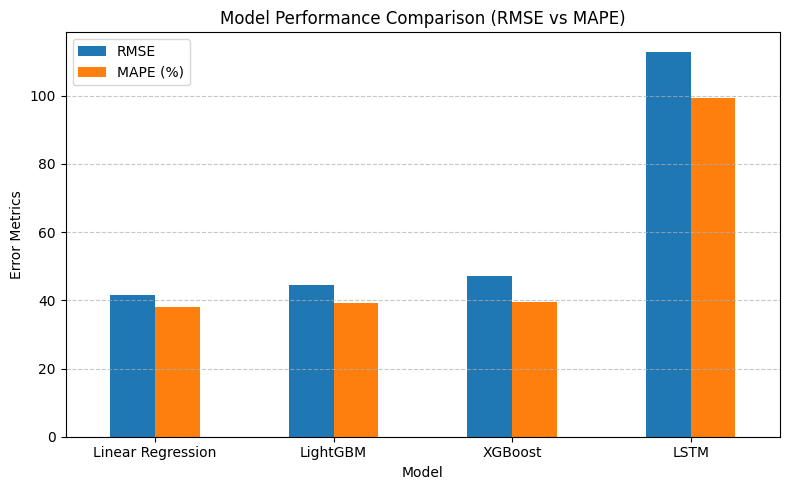


Figure 4.6 saved: drive/MyDrive/Rulinga II/model_comparison.png


In [ ]:
# -------------------------------------------------------------
# Hepatitis B Model Evaluation and Comparison (BMH)
# -------------------------------------------------------------
# Purpose
#   - Evaluate all trained models (XGBoost, LightGBM, Linear Regression, LSTM)
#   - Compute MSE, RMSE, MAE, MAPE
#   - Generate a Table and Figure
# -------------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings("ignore")
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


# -------------------------------------------------------------
# Step 1. Load datasets
# -------------------------------------------------------------
base_path = "drive/MyDrive/Rulinga II/"

print("Loading data for evaluation...")

df_long = pd.read_csv(os.path.join(base_path, "DIAGNOSIS_RESULTS_monthly_long.csv"), parse_dates=['month'])
df_temporal = pd.read_csv(os.path.join(base_path, "DIAGNOSIS_RESULTS_monthly_temporal.csv"), parse_dates=['month'])
df_missing = pd.read_csv(os.path.join(base_path, "DIAGNOSIS_RESULTS_monthly_ml_missing.csv"), parse_dates=['month'])

# --- Recreate patient_count ---
monthly_counts = df_long.groupby('month')['OPIP_CODE'].nunique().reset_index()
monthly_counts.rename(columns={'OPIP_CODE': 'patient_count'}, inplace=True)

# Merge features
df_feat = df_temporal.merge(monthly_counts, on='month', how='left')
df_feat = df_feat.merge(
    df_missing[['OPIP_CODE', 'month', 'mask_ALT_LEVEL', 'mask_VIRAL_LOAD', 'dropout_indicator', 'ipw']],
    on=['OPIP_CODE', 'month'], how='left'
)

print(f"Data successfully merged: {df_feat.shape[0]} records, {df_feat.shape[1]} columns\n")

# -------------------------------------------------------------
# Step 2. Define features and target
# -------------------------------------------------------------
target_col = 'patient_count'
feature_cols = [
    'ALT_LEVEL', 'VIRAL_LOAD', 'ALT_LEVEL_lag1', 'ALT_LEVEL_lag3', 'ALT_LEVEL_lag6',
    'VIRAL_LOAD_lag1', 'VIRAL_LOAD_lag3', 'VIRAL_LOAD_lag6',
    'ALT_LEVEL_ma1', 'ALT_LEVEL_ma3', 'ALT_LEVEL_ma6',
    'VIRAL_LOAD_ma1', 'VIRAL_LOAD_ma3', 'VIRAL_LOAD_ma6',
    'mask_ALT_LEVEL', 'mask_VIRAL_LOAD', 'dropout_indicator', 'AGE', 'GENDER'
]

df_feat = df_feat.replace([np.inf, -np.inf], np.nan).fillna(0)
X_tab = df_feat[feature_cols]
y_tab = df_feat[target_col]

# Chronological split
split_index = int(0.8 * len(X_tab))
X_train, X_test = X_tab.iloc[:split_index], X_tab.iloc[split_index:]
y_train, y_test = y_tab.iloc[:split_index], y_tab.iloc[split_index:]

# Scale features for LSTM (same as training phase)
scaler = StandardScaler()
scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Prepared evaluation dataset with {len(X_test)} test samples.\n")

# -------------------------------------------------------------
# Step 3. Metrics function
# -------------------------------------------------------------
def eval_metrics(y_true, y_pred):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[mask], y_pred[mask]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100
    return round(mse, 3), round(rmse, 3), round(mae, 3), round(mape, 3)

# -------------------------------------------------------------
# Step 4. Load all models
# -------------------------------------------------------------
print("Loading trained models...\n")
models = {}

try:
    models["XGBoost"] = joblib.load(os.path.join(base_path, "xgb_model.pkl"))
    print(" - XGBoost model loaded.")
except:
    print(" - XGBoost not found.")

try:
    models["LightGBM"] = joblib.load(os.path.join(base_path, "lgb_model.pkl"))
    print(" - LightGBM model loaded.")
except:
    print(" - LightGBM not found.")

try:
    models["Linear Regression"] = joblib.load(os.path.join(base_path, "lr_model.pkl"))
    print(" - Linear Regression model loaded.")
except:
    print(" - Linear Regression not found.")

# --- Improved LSTM loading block ---
lstm_path_h5 = os.path.join(base_path, "lstm_tuned_model.h5")
lstm_path_keras = os.path.join(base_path, "lstm_tuned_model.keras")

try:
    if os.path.exists(lstm_path_h5):
        models["LSTM"] = tf.keras.models.load_model(
            lstm_path_h5,
            custom_objects={'mse': tf.keras.losses.MeanSquaredError()}
        )
        print(" - LSTM model (.h5) loaded successfully.\n")

    elif os.path.exists(lstm_path_keras):
        models["LSTM"] = tf.keras.models.load_model(
            lstm_path_keras,
            custom_objects={'mse': tf.keras.losses.MeanSquaredError()}
        )
        print(" - LSTM model (.keras) loaded successfully.\n")

    else:
        print(" - LSTM model not found in either format.\n")

except Exception as e:
    print(f" - Error loading LSTM model: {e}\n")

# -------------------------------------------------------------
# Step 5. Evaluate models
# -------------------------------------------------------------
results = []
for name, model in models.items():
    print(f"Evaluating {name}...")

    try:
        if name == "LSTM":
            X_seq = np.expand_dims(X_test_scaled, axis=1)
            y_pred = model.predict(X_seq).flatten()
        else:
            y_pred = model.predict(X_test)

        mse, rmse, mae, mape = eval_metrics(y_test, y_pred)
        results.append([name, mse, rmse, mae, mape])
        print(f"   {name} evaluation complete.\n")

    except Exception as e:
        print(f"   Error evaluating {name}: {e}\n")

# -------------------------------------------------------------
# Step 6. Summarise results
# -------------------------------------------------------------
if results:
    model_metrics = pd.DataFrame(results, columns=["Model", "MSE", "RMSE", "MAE", "MAPE (%)"])
    model_metrics.set_index("Model", inplace=True)
    model_metrics = model_metrics.sort_values("RMSE")

    print("\n--- Model Performance Metrics ---")
    print(model_metrics)
    model_metrics.to_csv(os.path.join(base_path, "model_metrics_eval.csv"), index=True)
    print(f"\nResults saved to: {base_path}model_metrics_eval.csv")

    best_model = model_metrics["RMSE"].idxmin()
    print(f"\nBest-performing model based on RMSE: {best_model}")

    # ---------------------------------------------------------
    # Step 7. Generate Comparison Plot
    # ---------------------------------------------------------
    plt.figure(figsize=(8, 5))
    model_metrics[['RMSE', 'MAPE (%)']].plot(kind='bar', ax=plt.gca())
    plt.title('Model Performance Comparison (RMSE vs MAPE)', fontsize=12)
    plt.xlabel('Model')
    plt.ylabel('Error Metrics')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(os.path.join(base_path, "model_comparison.png"), dpi=300)
    plt.show()

    print(f"\nFigure 4.6 saved: {base_path}model_comparison.png")

else:
    print("No models evaluated successfully.")


## Forecasting (2025–2029)


Best model (Linear Regression) loaded successfully.

Columns detected in yearly dataset: ['OPIP_CODE', 'year', 'UHID', 'GENDER', 'AGE', 'VIRAL_LOAD', 'ALT_LEVEL', 'VIRAL_LOAD_LOG', 'LTFU']
No patient count column found — computing yearly patient counts from OPIP_CODE...
Aggregated yearly patient counts. 7 records ready.



Bootstrapping Yearly Forecast: 100%|██████████| 1000/1000 [00:05<00:00, 188.82it/s]



Forecasted Yearly Patient Counts (2025–2029)

 Year  Predicted_Mean  Lower_95_CI  Upper_95_CI
 2025             703          193         1101
 2026             826          218         1324
 2027             950          243         1567
 2028            1073          270         1809
 2029            1197          297         2050


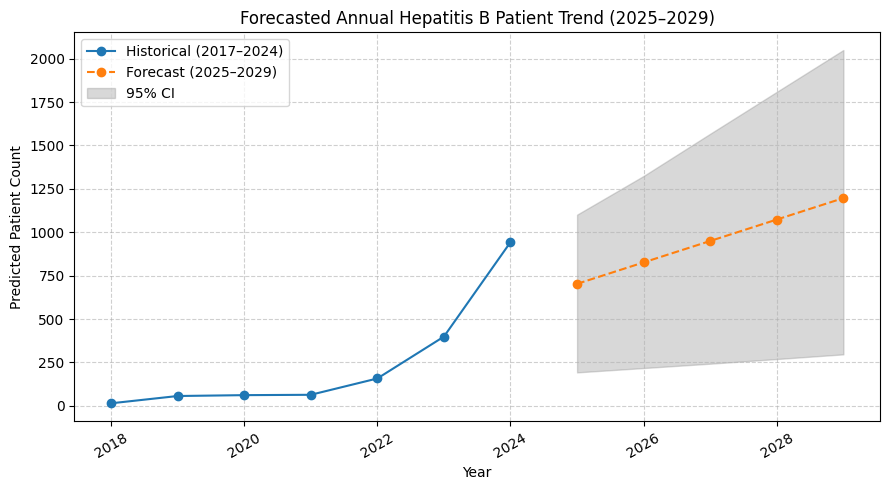

Bootstrapping Monthly Forecast: 100%|██████████| 500/500 [00:01<00:00, 310.31it/s]



Forecasted Monthly Patient Counts (2025–2029)

  Month  Predicted_Mean  Lower_95_CI  Upper_95_CI
2025-01              63           49           76
2025-02              64           50           78
2025-03              65           51           79
2025-04              66           52           80
2025-05              67           52           82
2025-06              68           53           83
2025-07              69           54           84
2025-08              70           55           86
2025-09              71           56           87
2025-10              72           56           89
2025-11              73           57           90
2025-12              74           58           91


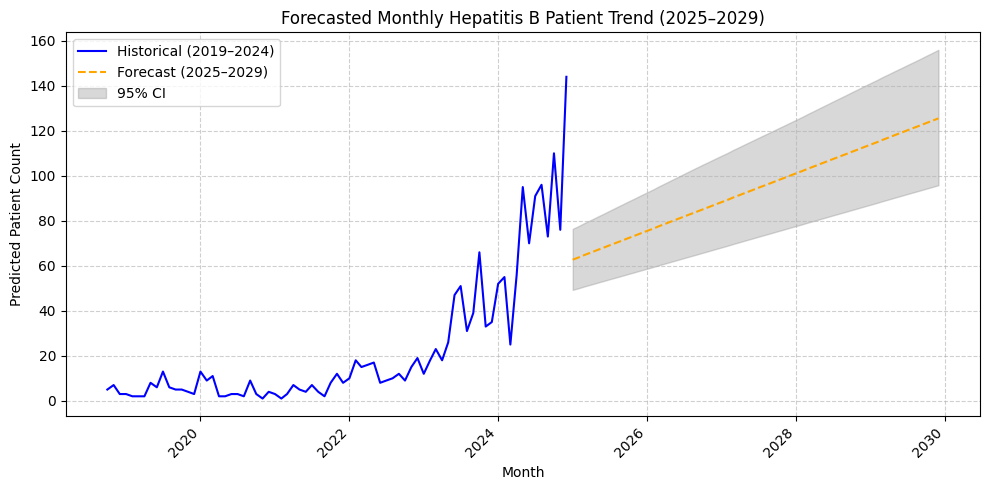


Forecast figures and tables generated successfully:
 - Yearly: drive/MyDrive/Rulinga II/plots/forecast_yearly_2025_2029.png
 - Monthly: drive/MyDrive/Rulinga II/plots/forecast_monthly_2025_2029.png


In [ ]:
# -------------------------------------------------------------
# Forecasting Module: Hepatitis B Patient Count (2025–2029)
# -------------------------------------------------------------

# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm

# -------------------------------------------------------------
# STEP 1. Load Trained Best Model
# -------------------------------------------------------------
model_path = "drive/MyDrive/Rulinga II/lr_model.pkl"
lr_model = joblib.load(model_path)
print("Best model (Linear Regression) loaded successfully.\n")


# -------------------------------------------------------------
# STEP 2. YEARLY FORECAST (2017–2029)
# -------------------------------------------------------------
yearly_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_yearly_agg.csv"
df_yearly = pd.read_csv(yearly_path)

print("Columns detected in yearly dataset:", list(df_yearly.columns))

# --- Detect year column ---
year_col = None
for c in df_yearly.columns:
    if 'year' in c.lower():
        year_col = c
        break
if year_col is None:
    raise KeyError("No 'year' column found in dataset.")

# --- Aggregate patient counts if missing ---
if not any('patient' in c.lower() or 'count' in c.lower() for c in df_yearly.columns):
    print("No patient count column found — computing yearly patient counts from OPIP_CODE...")
    df_yearly = (
        df_yearly.groupby(year_col)['OPIP_CODE']
        .nunique()
        .reset_index(name='patient_count')
    )
else:
    # rename existing patient column
    for c in df_yearly.columns:
        if 'patient' in c.lower() or 'count' in c.lower():
            df_yearly.rename(columns={c: 'patient_count'}, inplace=True)

df_yearly['Year'] = pd.to_numeric(df_yearly[year_col], errors='coerce').astype('Int64')
df_yearly = df_yearly.dropna(subset=['Year']).sort_values('Year')

print(f"Aggregated yearly patient counts. {len(df_yearly)} records ready.\n")

# --- Training Data ---
X_year = df_yearly[['Year']]
y_year = df_yearly['patient_count']

# --- Forecast years ---
future_years = np.arange(2025, 2030)
X_future_year = pd.DataFrame(future_years, columns=['Year'])

# --- Bootstrap Forecasts ---
boot_preds_year = []
for _ in tqdm(range(1000), desc="Bootstrapping Yearly Forecast"):
    sample_idx = np.random.choice(len(X_year), len(X_year), replace=True)
    X_sample, y_sample = X_year.iloc[sample_idx], y_year.iloc[sample_idx]
    lr_model.fit(X_sample, y_sample)
    boot_preds_year.append(lr_model.predict(X_future_year))

boot_preds_year = np.array(boot_preds_year)
forecast_mean_year = boot_preds_year.mean(axis=0)
lower_year = np.percentile(boot_preds_year, 2.5, axis=0)
upper_year = np.percentile(boot_preds_year, 97.5, axis=0)

# --- Table ---
forecast_table_year = pd.DataFrame({
    'Year': future_years,
    'Predicted_Mean': forecast_mean_year.round(0).astype(int),
    'Lower_95_CI': np.maximum(lower_year, 0).round(0).astype(int),
    'Upper_95_CI': upper_year.round(0).astype(int)
})
print("\nForecasted Yearly Patient Counts (2025–2029)\n")
print(forecast_table_year.to_string(index=False))
forecast_table_year.to_csv("drive/MyDrive/Rulinga II/forecast_yearly_2025_2029.csv", index=False)

# --- Plot Yearly Forecast ---
plt.figure(figsize=(9, 5))
plt.plot(df_yearly['Year'], df_yearly['patient_count'], marker='o', label='Historical (2017–2024)')
plt.plot(future_years, forecast_mean_year, marker='o', linestyle='--', label='Forecast (2025–2029)')
plt.fill_between(future_years, lower_year, upper_year, color='gray', alpha=0.3, label='95% CI')
plt.title("Forecasted Annual Hepatitis B Patient Trend (2025–2029)", fontsize=12)
plt.xlabel("Year")
plt.ylabel("Predicted Patient Count")
plt.xticks(rotation=30)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("drive/MyDrive/Rulinga II/plots/forecast_yearly_2025_2029.png", dpi=300)
plt.show()


# -------------------------------------------------------------
# STEP 3. MONTHLY FORECAST (2019–2029)
# -------------------------------------------------------------
monthly_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv"
df_month = pd.read_csv(monthly_path, parse_dates=['month'])
df_month['month_num'] = df_month['month'].dt.to_period('M').dt.to_timestamp()
monthly_counts = df_month.groupby('month_num')['OPIP_CODE'].nunique().reset_index(name='patient_count')
monthly_counts = monthly_counts.sort_values('month_num')

monthly_counts['t'] = np.arange(len(monthly_counts))
X_month = monthly_counts[['t']]
y_month = monthly_counts['patient_count']

future_months = pd.date_range(
    start=monthly_counts['month_num'].max() + pd.offsets.MonthBegin(1),
    periods=60, freq='MS'
)
X_future_month = pd.DataFrame({'t': np.arange(len(monthly_counts), len(monthly_counts) + len(future_months))})

boot_preds_month = []
for _ in tqdm(range(500), desc="Bootstrapping Monthly Forecast"):
    sample_idx = np.random.choice(len(X_month), len(X_month), replace=True)
    X_sample, y_sample = X_month.iloc[sample_idx], y_month.iloc[sample_idx]
    lr_model.fit(X_sample, y_sample)
    boot_preds_month.append(lr_model.predict(X_future_month))

boot_preds_month = np.array(boot_preds_month)
forecast_mean_month = boot_preds_month.mean(axis=0)
lower_month = np.percentile(boot_preds_month, 2.5, axis=0)
upper_month = np.percentile(boot_preds_month, 97.5, axis=0)

forecast_table_month = pd.DataFrame({
    'Month': future_months.strftime('%Y-%m'),
    'Predicted_Mean': forecast_mean_month.round(0).astype(int),
    'Lower_95_CI': np.maximum(lower_month, 0).round(0).astype(int),
    'Upper_95_CI': upper_month.round(0).astype(int)
})
print("\nForecasted Monthly Patient Counts (2025–2029)\n")
print(forecast_table_month.head(12).to_string(index=False))
forecast_table_month.to_csv("drive/MyDrive/Rulinga II/forecast_monthly_2025_2029.csv", index=False)

plt.figure(figsize=(10, 5))
plt.plot(monthly_counts['month_num'], monthly_counts['patient_count'], color='blue', label='Historical (2019–2024)')
plt.plot(future_months, forecast_mean_month, color='orange', linestyle='--', label='Forecast (2025–2029)')
plt.fill_between(future_months, lower_month, upper_month, color='gray', alpha=0.3, label='95% CI')
plt.title("Forecasted Monthly Hepatitis B Patient Trend (2025–2029)", fontsize=12)
plt.xlabel("Month")
plt.ylabel("Predicted Patient Count")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("drive/MyDrive/Rulinga II/plots/forecast_monthly_2025_2029.png", dpi=300)
plt.show()

print("\nForecast figures and tables generated successfully:")
print(" - Yearly: drive/MyDrive/Rulinga II/plots/forecast_yearly_2025_2029.png")
print(" - Monthly: drive/MyDrive/Rulinga II/plots/forecast_monthly_2025_2029.png")
